In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

from sksurv.datasets import load_gbsg2
from sksurv.datasets import get_x_y
from sksurv.preprocessing import OneHotEncoder
from sksurv.ensemble import RandomSurvivalForest

from sklearn.decomposition import PCA
from sklearn.linear_model import LassoCV, LinearRegression
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import f1_score, accuracy_score, mean_absolute_error
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.inspection import permutation_importance
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram
from scipy.spatial.distance import squareform
from sksurv.metrics import (
    concordance_index_censored,
    concordance_index_ipcw,
    cumulative_dynamic_auc,
    integrated_brier_score,
    brier_score
)
from sklearn.impute import KNNImputer

import PyWGCNA
import biomart
import gseapy as gp

from lifelines import CoxPHFitter

from xgboost import XGBRegressor
import optuna

from tqdm import tqdm
import pickle

## Load data

### RNA-seq data

In [2]:
rnaseq = pd.read_csv("data/data_mrna_seq_tpm.txt", sep="\t")
rnaseq = rnaseq.set_index("Hugo_Symbol")

rnaseq.head()

,SCLL-0003,SCLL-0004,SCLL-0005,SCLL-0007,SCLL-0008,SCLL-0009,SCLL-0010,SCLL-0012,SCLL-0014,SCLL-0015,...,GCLL-0341,GCLL-0342,GCLL-0343,GCLL-0344,GCLL-0345,JB-0015,MDAC-0022,MDAC-0024,NHLBI-0052,NHLBI-0053
Hugo_Symbol,,,,,,,,,,,,,,,,,,,,,
DDX11L1,0.182931,0.067721,0.067218,0.072244,0.00000,0.040055,0.083875,0.045353,0.072649,0.098573,...,0.090520,0.135813,0.176484,0.055676,0.164923,0.177906,0.245936,0.167029,0.043638,0.240493
WASH7P,16.918500,13.280000,11.274000,12.116900,7.23365,10.936600,11.403300,9.066530,16.591000,15.497600,...,14.253600,15.247300,6.062090,8.194370,6.444970,19.289700,12.638500,16.242700,14.989200,19.740200
MIR1302-11,0.085805,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.039001,0.024989,0.067814,...,0.190281,0.124577,0.182119,0.191511,0.113459,0.203985,0.281987,0.172362,0.075052,0.124086
FAM138A,0.047912,0.048777,0.032276,0.000000,0.00000,0.000000,0.000000,0.032666,0.020930,0.000000,...,0.101420,0.078257,0.076269,0.080202,0.110869,0.128139,0.039364,0.144366,0.062861,0.000000
OR4G4P,0.092510,0.031393,0.000000,0.000000,0.00000,0.000000,0.000000,0.042048,0.000000,0.000000,...,0.037300,0.117523,0.081813,0.077429,0.040775,0.054981,0.101341,0.000000,0.040458,0.000000


In [3]:
rnaseq_small = pd.read_csv("data/rnaseq/rnaseq_by_single_cox.csv")

rnaseq_small.head()

,covariate,CRC-0001,CRC-0002,CRC-0003,CRC-0004,CRC-0005,CRC-0006,CRC-0007,CRC-0009,CRC-0010,...,SCLL-0489,SCLL-0491,SCLL-0495,SCLL-0497,SCLL-0498,SCLL-0499,SCLL-0502,SCLL-0503,SCLL-0504,SCLL-0505
0,VPS26B,7.79403,10.87720,13.92850,11.19700,6.788440,9.67798,15.15110,22.00690,17.15920,...,19.96570,17.50420,14.38850,19.58770,28.00320,11.65860,27.44240,10.74740,3.57610,5.38726
1,JDP2,2.98499,4.33715,4.58612,11.52150,4.118540,4.13609,4.13003,6.87632,6.01199,...,11.70920,5.95714,4.65863,13.89810,9.70937,6.37764,10.48260,7.80804,4.10732,3.68045
2,FCRL3,216.59900,7.62117,47.29920,215.67100,33.856400,19.84460,196.42200,33.63430,374.22800,...,766.84000,90.46160,295.84100,151.84000,428.94200,235.84200,531.27100,295.40200,149.26500,9.66782
3,RP11-134P9.3,1.18650,3.58340,2.86752,3.49743,0.707394,1.95985,1.74239,1.65236,2.00009,...,2.10552,1.35991,1.48274,2.90852,2.53676,3.61197,1.69386,3.36395,4.14438,4.15319
4,LPCAT1,33.79640,31.98280,19.06380,39.71760,12.524000,32.91010,35.45170,16.57070,23.07600,...,57.76580,42.07090,45.92910,45.76170,41.87910,47.68180,69.52560,25.22730,29.35740,14.41010


### Samples data

In [4]:
samples = pd.read_csv("data/data_clinical_sample.txt", sep="\t", skiprows=4)
samples = samples[(samples.DISEASE_TYPE == "CLL") &
                  (samples.RNA_SEQUENCING == "Yes")]
samples.head()

,PATIENT_ID,SAMPLE_ID,CENTER,ONCOTREE_CODE,DISEASE_TYPE,NORMAL_MEAN_COVERAGE,TUMOR_MEAN_COVERAGE,TUMOR_SAMPLE_PURITY,TUMOR_SAMPLE_PLOIDY,CANCER_TYPE,...,RNA_SEQUENCING,RRBS,ARRAY450K,M-CLL_WES,U-CLL_WES,EC_DISCOVERY,EC_EXTENSION,IGLV3_21_R110,U1_STATUS,TMB_NONSYNONYMOUS
0,P-CRC-0001,CRC-0001,Broad,CLLSLL,CLL,63.0,79.7,0.92,2.00,Mature B-Cell Neoplasms,...,Yes,Yes,No,No,Yes,Yes,No,No,WT,0.866667
1,P-CRC-0002,CRC-0002,Broad,CLLSLL,CLL,70.1,135.5,0.94,2.03,Mature B-Cell Neoplasms,...,Yes,Yes,No,No,Yes,Yes,No,No,WT,0.766667
2,P-CRC-0003,CRC-0003,Broad,CLLSLL,CLL,77.2,141.1,0.83,2.05,Mature B-Cell Neoplasms,...,Yes,Yes,No,No,Yes,Yes,No,No,WT,0.233333
3,P-CRC-0004,CRC-0004,Broad,CLLSLL,CLL,60.2,146.0,0.92,2.00,Mature B-Cell Neoplasms,...,Yes,Yes,No,Yes,No,Yes,No,No,WT,1.000000
4,P-CRC-0005,CRC-0005,Broad,CLLSLL,CLL,106.5,82.1,0.87,2.05,Mature B-Cell Neoplasms,...,Yes,Yes,No,No,Yes,Yes,No,No,WT,0.766667


In [5]:
categorical_cols = samples.dtypes[samples.dtypes == object].index

for catcol in categorical_cols[2:]:
    if samples[catcol].nunique() >= 2:
        print(samples[catcol].value_counts(), "\n")

CLL_EPITYPE
n-CLL           241
m-CLL           225
i-CLL            83
0                49
unclassified     10
Name: count, dtype: int64 

TUMOR_MOLECULAR_SUBTYPE
M-CLL    302
U-CLL    298
Name: count, dtype: int64 

SEQUENCING_PLATFORM
WES        470
WGS         78
WES/WGS     68
Name: count, dtype: int64 

RRBS
Yes    349
No     341
Name: count, dtype: int64 

ARRAY450K
No     429
Yes    261
Name: count, dtype: int64 

M-CLL_WES
No     413
Yes    277
Name: count, dtype: int64 

U-CLL_WES
No     438
Yes    252
Name: count, dtype: int64 

EC_DISCOVERY
Yes    603
No      87
Name: count, dtype: int64 

EC_EXTENSION
No     610
Yes     80
Name: count, dtype: int64 

IGLV3_21_R110
No     620
Yes     54
Name: count, dtype: int64 

U1_STATUS
WT     551
MUT     24
Name: count, dtype: int64 



In [6]:
samples = samples[samples.SAMPLE_ID.isin(rnaseq.columns)]

samples_counts = samples.PATIENT_ID.value_counts() 
duplicated_patients = samples_counts[samples_counts > 1].index

samples[samples.PATIENT_ID.isin(duplicated_patients)]

,PATIENT_ID,SAMPLE_ID,CENTER,ONCOTREE_CODE,DISEASE_TYPE,NORMAL_MEAN_COVERAGE,TUMOR_MEAN_COVERAGE,TUMOR_SAMPLE_PURITY,TUMOR_SAMPLE_PLOIDY,CANCER_TYPE,...,RNA_SEQUENCING,RRBS,ARRAY450K,M-CLL_WES,U-CLL_WES,EC_DISCOVERY,EC_EXTENSION,IGLV3_21_R110,U1_STATUS,TMB_NONSYNONYMOUS
6,P-CRC-0007,CRC-0007,Broad,CLLSLL,CLL,68.5,96.7,0.86,1.98,Mature B-Cell Neoplasms,...,Yes,Yes,No,Yes,No,No,No,No,WT,0.833333
7,P-CRC-0007,DFCI-5193,Broad,CLLSLL,CLL,NaN,NaN,NaN,NaN,Mature B-Cell Neoplasms,...,Yes,No,No,No,No,Yes,No,NaN,WT,NaN
9,P-CRC-0009,CRC-0009,Broad,CLLSLL,CLL,62.0,60.0,0.77,2.01,Mature B-Cell Neoplasms,...,Yes,Yes,No,Yes,No,Yes,No,No,WT,0.500000
10,P-CRC-0009,JB-0010,Broad,CLLSLL,CLL,NaN,NaN,NaN,NaN,Mature B-Cell Neoplasms,...,Yes,No,No,No,No,No,No,No,WT,NaN
12,P-CRC-0011,CRC-0011,Broad,CLLSLL,CLL,142.4,54.3,0.92,2.04,Mature B-Cell Neoplasms,...,Yes,Yes,No,No,Yes,No,No,No,WT,0.633333
13,P-CRC-0011,DFCI-5170,Broad,CLLSLL,CLL,NaN,NaN,NaN,NaN,Mature B-Cell Neoplasms,...,Yes,No,No,No,No,Yes,No,No,WT,NaN
22,P-CRC-0020,CRC-0020,Broad,CLLSLL,CLL,89.4,62.4,0.85,2.00,Mature B-Cell Neoplasms,...,Yes,Yes,No,No,Yes,Yes,No,No,WT,0.366667
23,P-CRC-0020,DFCI-5053,Broad,CLLSLL,CLL,NaN,NaN,NaN,NaN,Mature B-Cell Neoplasms,...,Yes,No,No,No,No,No,No,No,MUT,NaN


In [7]:
samples_to_drop = samples[samples.SAMPLE_ID.isin(["DFCI-5193", "JB-0010", "DFCI-5170", "DFCI-5053"])].index

samples = samples.drop(samples_to_drop, axis=0)

### Patient data

In [8]:
patients = pd.read_csv("data/data_clinical_patient.txt", sep="\t", skiprows=4)

patients.head()

,PATIENT_ID,AGE,AGE_SAMPLING,SEX,OS_STATUS,OS_MONTHS,DEATH_DAYS,COHORT,IGHV_MUTATION_STATUS,IGHV_IDENTITY_PERCENTAGE,TREATMENT_STATUS,PRIOR_TREATMENT_CATEGORY,TREATMENT_AFTER_SAMPLING,EXPRESSION_CLUSTER,FFS_STATUS,FFS_MONTHS
0,P-CRC-0001,44.0,46.0,Female,DECEASED,147.19,4477.0,UCSD,unmutated,100.00,Pre-treatment,Untreated,Chemo + Ab,EC-u1,1:Failure,43.17
1,P-CRC-0002,55.0,56.0,Male,DECEASED,154.49,4699.0,UCSD,unmutated,100.00,Pre-treatment,Untreated,Chemo + Ab,EC-u1,1:Failure,66.64
2,P-CRC-0003,63.0,63.0,Female,DECEASED,51.25,1559.0,UCSD,unmutated,100.00,Pre-treatment,Untreated,Chemo + Ab,EC-u2,1:Failure,27.75
3,P-CRC-0004,51.0,51.0,Male,LIVING,183.55,0.0,UCSD,mutated,92.28,Pre-treatment,Untreated,Chemo + Ab,EC-m4,1:Failure,92.48
4,P-CRC-0005,36.0,37.0,Male,LIVING,164.35,0.0,UCSD,unmutated,100.00,Pre-treatment,Untreated,Chemo + Ab,EC-u2,1:Failure,59.57


In [9]:
patients = patients.dropna(subset=["OS_STATUS", "OS_MONTHS"])

## Keep patients and samples presented in all tables

In [10]:
patient_ids = set(patients.PATIENT_ID) & set(samples.PATIENT_ID)

patients = patients[patients.PATIENT_ID.isin(patient_ids)]
samples = samples[samples.PATIENT_ID.isin(patient_ids)]
rnaseq = rnaseq.loc[:, samples.SAMPLE_ID]

In [11]:
patients.shape, samples.shape, rnaseq.shape

((609, 16), (609, 25), (57242, 609))

## RNA-seq preprocessing

In [12]:
rnaseq = rnaseq.groupby(level="Hugo_Symbol").sum()

<Axes: >

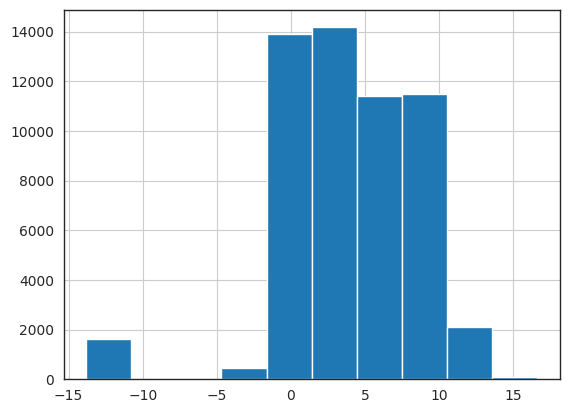

In [13]:
np.log(rnaseq.sum(axis=1) + 1e-6).hist()

<Axes: >

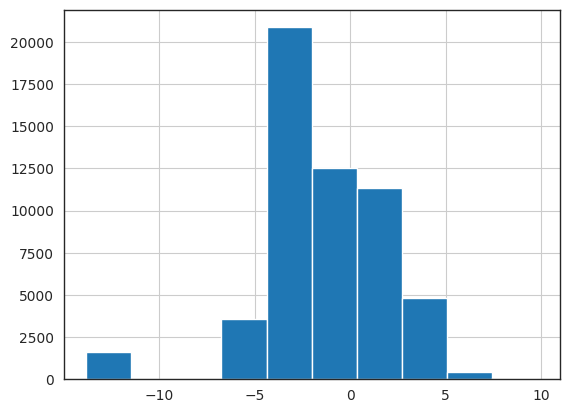

In [14]:
np.log(rnaseq.std(axis=1) + 1e-6).hist()

In [15]:
rnaseq = rnaseq[np.log(rnaseq.sum(axis=1) + 1e-6) > 0]
rnaseq = rnaseq[np.log(rnaseq.std(axis=1) + 1e-6) > -4]

rnaseq.shape

(45375, 609)

## Train-test Split

In [16]:
X = (rnaseq.reset_index() 
            .rename({"Hugo_Symbol": "SAMPLE_ID"}, axis=1)
            .set_index("SAMPLE_ID")
            .T)

y = (patients[["OS_MONTHS", "OS_STATUS"]]
        .rename({"OS_STATUS": "event", "OS_MONTHS": "event_time"}, axis=1))
y["event"] = y["event"].replace({"DECEASED": 1, "LIVING": 0}) * 30.5 
y = y.astype(int)

y.index = X.index

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.15, random_state=42)
X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape

((439, 45375), (78, 45375), (92, 45375), (439, 2), (78, 2), (92, 2))

In [18]:
X_train_small = X_train[rnaseq_small.covariate]
X_val_small = X_val[rnaseq_small.covariate]
X_test_small = X_test[rnaseq_small.covariate]

X_train_small.shape, X_val_small.shape

((439, 1386), (78, 1386))

## Feature selection

In [19]:
single_feature_cox_results = pd.DataFrame()

for col in tqdm(X_train.columns):
    try:
        Cox_train = pd.concat([X_train.loc[:, [col]], y_train], axis=1)

        cph = CoxPHFitter()
        cph.fit(Cox_train, duration_col = "event_time", event_col = "event")

        single_feature_cox_results = pd.concat([single_feature_cox_results, cph.summary])
    except:
        print(col)

  2%|▏         | 816/45375 [00:42<38:23, 19.35it/s]  

AC007316.3


  3%|▎         | 1324/45375 [01:11<47:42, 15.39it/s]  

AC011994.1


  3%|▎         | 1338/45375 [01:12<37:18, 19.67it/s]

AC012175.1


  3%|▎         | 1411/45375 [01:16<36:17, 20.19it/s]

AC013268.1


  4%|▍         | 1711/45375 [01:32<37:42, 19.30it/s]

AC020934.1


  4%|▍         | 1792/45375 [01:36<34:33, 21.02it/s]

AC024569.1


  4%|▍         | 1813/45375 [01:37<37:15, 19.49it/s]

AC025458.1


  4%|▍         | 1904/45375 [01:42<36:23, 19.91it/s]

AC051642.1


  5%|▍         | 2107/45375 [01:53<38:02, 18.95it/s]

AC073464.7


  5%|▍         | 2182/45375 [01:57<38:11, 18.85it/s]

AC079117.1


  5%|▌         | 2316/45375 [02:04<35:11, 20.40it/s]

AC090150.1


  5%|▌         | 2357/45375 [02:06<34:09, 20.99it/s]

AC090825.2


  6%|▌         | 2591/45375 [02:19<34:05, 20.92it/s]

AC096633.1


  6%|▌         | 2615/45375 [02:20<35:02, 20.33it/s]

AC097463.2


  6%|▌         | 2684/45375 [02:24<47:47, 14.89it/s]

AC099778.1
AC099799.1


  6%|▋         | 2933/45375 [02:37<39:17, 18.00it/s]

AC113607.3
AC114296.1


  7%|▋         | 3044/45375 [02:44<38:02, 18.55it/s]

AC126763.1


  7%|▋         | 3147/45375 [02:49<33:37, 20.94it/s]

AC138710.1


  8%|▊         | 3800/45375 [03:23<33:47, 20.50it/s]

AL022400.1


  8%|▊         | 3807/45375 [03:23<43:33, 15.91it/s]

AL031320.1


  8%|▊         | 3812/45375 [03:24<36:56, 18.75it/s]

AL031655.2


  9%|▊         | 3866/45375 [03:27<36:47, 18.81it/s]

AL117334.1


  9%|▊         | 3872/45375 [03:27<37:22, 18.51it/s]

AL121652.2


  9%|▊         | 3893/45375 [03:28<37:05, 18.64it/s]

AL121988.1


  9%|▊         | 3928/45375 [03:30<35:48, 19.29it/s]

AL136123.1


  9%|▉         | 4016/45375 [03:35<37:50, 18.22it/s]

AL163760.1


  9%|▉         | 4044/45375 [03:37<36:20, 18.95it/s]

AL354741.1


  9%|▉         | 4141/45375 [03:42<37:28, 18.33it/s]

AL445256.1


  9%|▉         | 4172/45375 [03:44<37:19, 18.40it/s]

AL590113.1


  9%|▉         | 4252/45375 [03:49<33:18, 20.58it/s]

AL691452.1


 10%|█         | 4615/45375 [04:07<32:00, 21.23it/s]

AP000318.1


 10%|█         | 4670/45375 [04:09<35:47, 18.96it/s]

AP000547.1


 10%|█         | 4717/45375 [04:12<34:15, 19.78it/s]

AP000797.4


 19%|█▊        | 8480/45375 [07:22<29:26, 20.89it/s]  

CTA-392C11.2


 22%|██▏       | 10136/45375 [08:44<27:04, 21.69it/s]

CTD-3244O18.5


 23%|██▎       | 10615/45375 [09:08<31:07, 18.61it/s]

DEFA5


 26%|██▋       | 11937/45375 [10:13<25:54, 21.50it/s]

FABP6


 27%|██▋       | 12448/45375 [10:38<26:19, 20.84it/s]

FCF1P9


 30%|███       | 13791/45375 [11:43<24:06, 21.84it/s]

GS1-5L10.1


 31%|███       | 13893/45375 [11:48<26:48, 19.57it/s]

GUCA2A


 33%|███▎      | 14904/45375 [12:37<25:06, 20.23it/s]

HSPD1P14


 33%|███▎      | 15125/45375 [12:48<25:09, 20.05it/s]

IGHD1-20
IGHD1-26


 34%|███▎      | 15265/45375 [12:56<24:42, 20.31it/s]

IGHV7-27


 35%|███▌      | 15936/45375 [13:30<23:36, 20.78it/s]

JRKL-AS1


 41%|████      | 18415/45375 [15:33<21:45, 20.65it/s]

MIR1249


 41%|████      | 18508/45375 [15:38<25:29, 17.56it/s]

MIR15B


 41%|████      | 18569/45375 [15:42<22:48, 19.59it/s]

MIR218-1


 41%|████      | 18607/45375 [15:44<25:08, 17.75it/s]

MIR3117


 41%|████      | 18696/45375 [15:49<21:43, 20.47it/s]

MIR3619


 41%|████▏     | 18785/45375 [15:54<22:47, 19.45it/s]

MIR4291


 42%|████▏     | 18839/45375 [15:57<24:35, 17.99it/s]

MIR4462


 42%|████▏     | 18989/45375 [16:06<22:12, 19.81it/s]

MIR4797


 42%|████▏     | 19017/45375 [16:07<19:57, 22.01it/s]

MIR502


 42%|████▏     | 19054/45375 [16:10<26:13, 16.72it/s]

MIR542


 42%|████▏     | 19076/45375 [16:11<27:13, 16.10it/s]

MIR548F3


 42%|████▏     | 19100/45375 [16:12<21:30, 20.37it/s]

MIR5584


 42%|████▏     | 19119/45375 [16:14<27:25, 15.95it/s]

MIR5696


 42%|████▏     | 19154/45375 [16:15<20:18, 21.52it/s]

MIR620


 43%|████▎     | 19580/45375 [16:36<20:21, 21.12it/s]

MRPS33P3


 45%|████▌     | 20588/45375 [17:26<19:30, 21.18it/s]

NMNAT1P3


 46%|████▌     | 20816/45375 [17:37<19:33, 20.93it/s]

NRG1-IT2


 48%|████▊     | 21640/45375 [18:17<18:31, 21.36it/s]

OR6M3P


 50%|█████     | 22867/45375 [19:17<18:00, 20.83it/s]

PNLIPP1


 54%|█████▎    | 24319/45375 [20:28<17:10, 20.44it/s]

RFPL4AP7


 54%|█████▍    | 24687/45375 [20:47<16:16, 21.20it/s]

RN7SKP75


 55%|█████▍    | 24864/45375 [20:55<15:30, 22.05it/s]

RN7SL254P


 55%|█████▌    | 25146/45375 [21:09<16:43, 20.15it/s]

RN7SL539P


 56%|█████▌    | 25417/45375 [21:23<21:44, 15.30it/s]

RN7SL820P


 56%|█████▌    | 25516/45375 [21:27<16:14, 20.38it/s]

RNA5SP153


 56%|█████▌    | 25522/45375 [21:28<15:55, 20.78it/s]

RNA5SP165


 56%|█████▋    | 25528/45375 [21:28<15:29, 21.35it/s]

RNA5SP176


 56%|█████▋    | 25586/45375 [21:31<15:28, 21.32it/s]

RNA5SP255
RNA5SP26
RNA5SP261


 57%|█████▋    | 25695/45375 [21:37<16:40, 19.67it/s]

RNA5SP421


 57%|█████▋    | 25771/45375 [21:41<18:24, 17.75it/s]

RNA5SP60


 57%|█████▋    | 25959/45375 [21:51<16:44, 19.33it/s]

RNU1-141P


 58%|█████▊    | 26332/45375 [22:11<15:56, 19.90it/s]

RNU6-1200P


 58%|█████▊    | 26446/45375 [22:18<16:00, 19.72it/s]

RNU6-159P


 58%|█████▊    | 26527/45375 [22:22<19:24, 16.18it/s]

RNU6-275P


 58%|█████▊    | 26537/45375 [22:23<16:18, 19.25it/s]

RNU6-292P


 59%|█████▊    | 26581/45375 [22:25<22:58, 13.63it/s]

RNU6-364P


 59%|█████▊    | 26606/45375 [22:27<17:03, 18.33it/s]

RNU6-397P


 59%|█████▉    | 26665/45375 [22:30<15:48, 19.74it/s]

RNU6-486P


 59%|█████▉    | 26723/45375 [22:33<17:16, 17.99it/s]

RNU6-56P


 59%|█████▉    | 26748/45375 [22:35<14:25, 21.53it/s]

RNU6-604P
RNU6-608P


 59%|█████▉    | 26838/45375 [22:40<16:48, 18.37it/s]

RNU6-741P


 59%|█████▉    | 26863/45375 [22:41<18:13, 16.92it/s]

RNU6-77P


 59%|█████▉    | 26918/45375 [22:44<16:07, 19.07it/s]

RNU6-861P


 60%|█████▉    | 27053/45375 [22:52<19:47, 15.43it/s]

RNU7-115P
RNU7-121P


 60%|█████▉    | 27067/45375 [22:53<17:56, 17.01it/s]

RNU7-151P


 60%|█████▉    | 27161/45375 [22:59<18:33, 16.36it/s]

RNY4P23


 64%|██████▍   | 29230/45375 [24:43<12:17, 21.89it/s]

RP11-192P9.1


 65%|██████▍   | 29320/45375 [24:47<12:04, 22.15it/s]

RP11-200A13.3


 66%|██████▌   | 29903/45375 [25:16<12:16, 20.99it/s]

RP11-258J10.1


 67%|██████▋   | 30358/45375 [25:38<11:28, 21.82it/s]

RP11-296L20.1


 68%|██████▊   | 30875/45375 [26:06<11:34, 20.86it/s]  

RP11-32I2.1


 68%|██████▊   | 30899/45375 [26:07<11:52, 20.32it/s]

RP11-332E19.1


 69%|██████▉   | 31457/45375 [26:34<11:23, 20.38it/s]

RP11-368L12.1


 71%|███████   | 32121/45375 [27:07<11:00, 20.06it/s]

RP11-415C15.3


 71%|███████   | 32169/45375 [27:10<10:50, 20.31it/s]

RP11-419K12.1


 72%|███████▏  | 32461/45375 [27:26<12:00, 17.91it/s]  

RP11-439I14.3


 72%|███████▏  | 32486/45375 [27:28<10:26, 20.57it/s]

RP11-440L16.1


 72%|███████▏  | 32713/45375 [27:39<10:07, 20.86it/s]

RP11-459A10.3


 76%|███████▋  | 34652/45375 [29:15<08:20, 21.41it/s]

RP11-648L3.1


 77%|███████▋  | 34772/45375 [29:21<08:56, 19.76it/s]

RP11-664H7.2


 78%|███████▊  | 35286/45375 [29:47<08:11, 20.53it/s]

RP11-726G23.6


 78%|███████▊  | 35321/45375 [29:49<08:10, 20.49it/s]

RP11-72M10.8


 82%|████████▏ | 37024/45375 [31:16<06:52, 20.23it/s]

RP3-495K2.2


 83%|████████▎ | 37801/45375 [31:55<06:05, 20.73it/s]

RP5-905H7.4


 85%|████████▌ | 38679/45375 [32:39<05:53, 18.95it/s]

RPS28P8


 88%|████████▊ | 39757/45375 [33:35<04:21, 21.46it/s]

SLC20A1P2
SLC20A1P3


 89%|████████▉ | 40429/45375 [34:07<04:19, 19.04it/s]

SNORD114-23


 89%|████████▉ | 40539/45375 [34:13<03:26, 23.47it/s]

SNORD56B


 90%|████████▉ | 40665/45375 [34:19<03:43, 21.05it/s]

SNX18P14


 92%|█████████▏| 41807/45375 [35:14<02:50, 20.88it/s]

TERT


 95%|█████████▍| 42992/45375 [36:17<02:01, 19.63it/s]

TRMT112P1


 96%|█████████▌| 43400/45375 [36:38<01:36, 20.42it/s]

UBE2DNL


 96%|█████████▌| 43489/45375 [36:43<01:28, 21.25it/s]

UBQLNL


 98%|█████████▊| 44433/45375 [37:33<00:53, 17.68it/s]

Z97053.1


100%|██████████| 45375/45375 [38:20<00:00, 19.72it/s]


In [21]:
genes = single_feature_cox_results.sort_values("p")[single_feature_cox_results.sort_values("p").p < 0.1].index
rnaseq_small = rnaseq.loc[genes]

In [114]:
X_train_small = X_train[rnaseq_small.index]
X_val_small = X_val[rnaseq_small.index]
X_test_small = X_test[rnaseq_small.index]

X_train_small.shape

(439, 13419)

In [22]:
rnaseq_small.to_csv("data/rnaseq/rnaseq_by_single_cox.csv")

# WGCNA

Saving data to be True, checking requirements ...
Pre-processing...
	Detecting genes and samples with too many missing values...
	Done pre-processing..



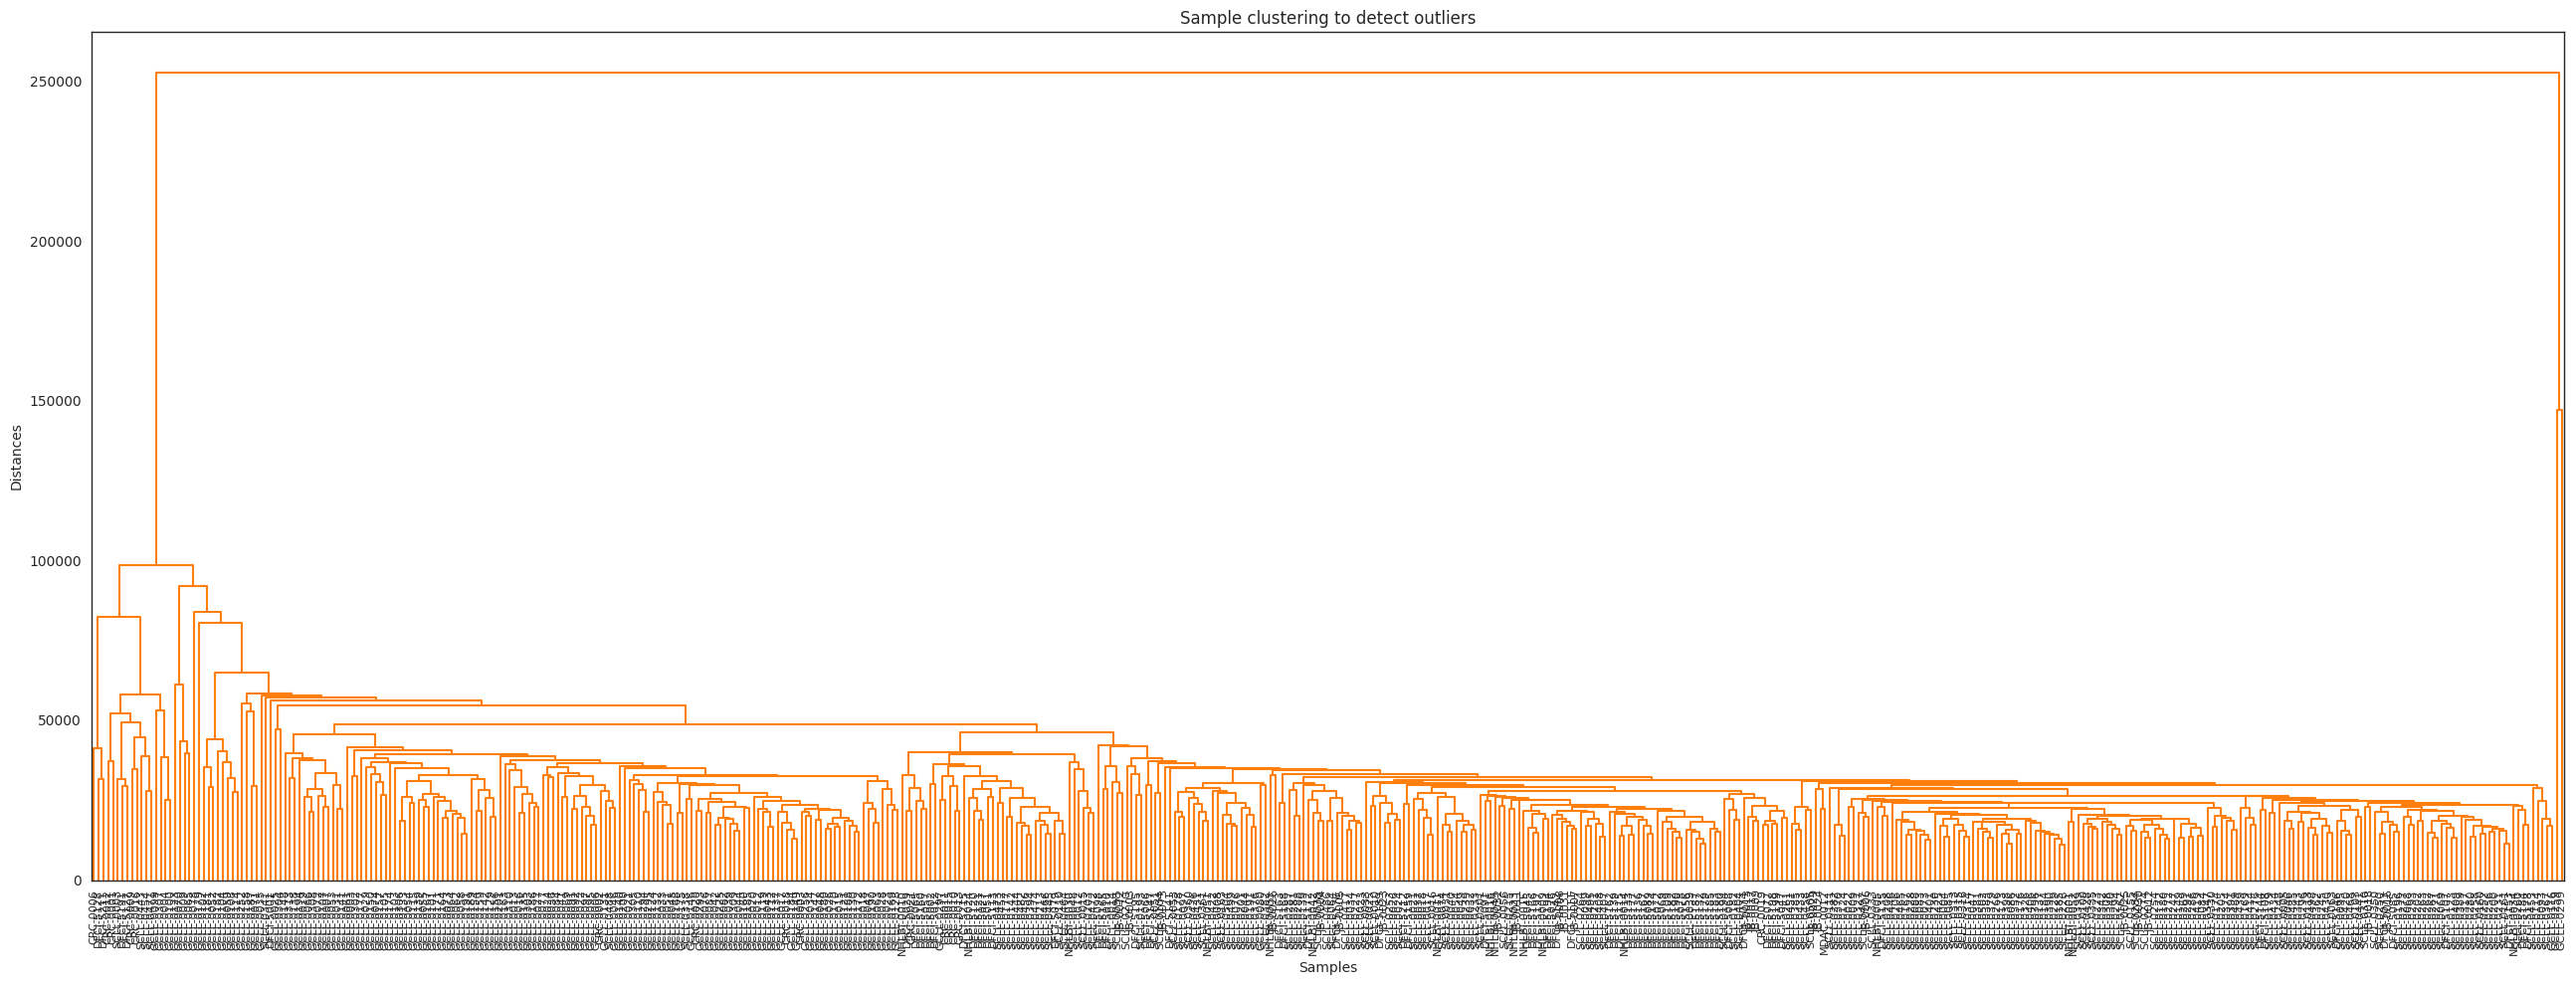

In [30]:
pyWGCNA_reprog = PyWGCNA.WGCNA(name='rnaseq_adults',
                               species='homo sapiens',
                               geneExp=X_train,
                               outputPath='wgcna_',
                               TPMcutoff=0,
                               save=True)
pyWGCNA_reprog.geneExpr.to_df()

pyWGCNA_reprog.preprocess()

In [103]:
samples_to_drop = ["CRC-0006", "DFCI-5128", "DFCI-5211", "GCLL-0259", "GCLL-0299", "GCLL-0123", "GCLL-0070"]
# samples_to_drop = ["GCLL-0259", "GCLL-0068", "GCLL-0070", "GCLL-0179"]

data_for_wgcna = X_train.drop(samples_to_drop)
data_for_wgcna = data_for_wgcna.loc[:, np.log(data_for_wgcna.mean(axis=0) + 1e-6) > -2]

Saving data to be True, checking requirements ...
Pre-processing...
	Detecting genes and samples with too many missing values...
	Done pre-processing..



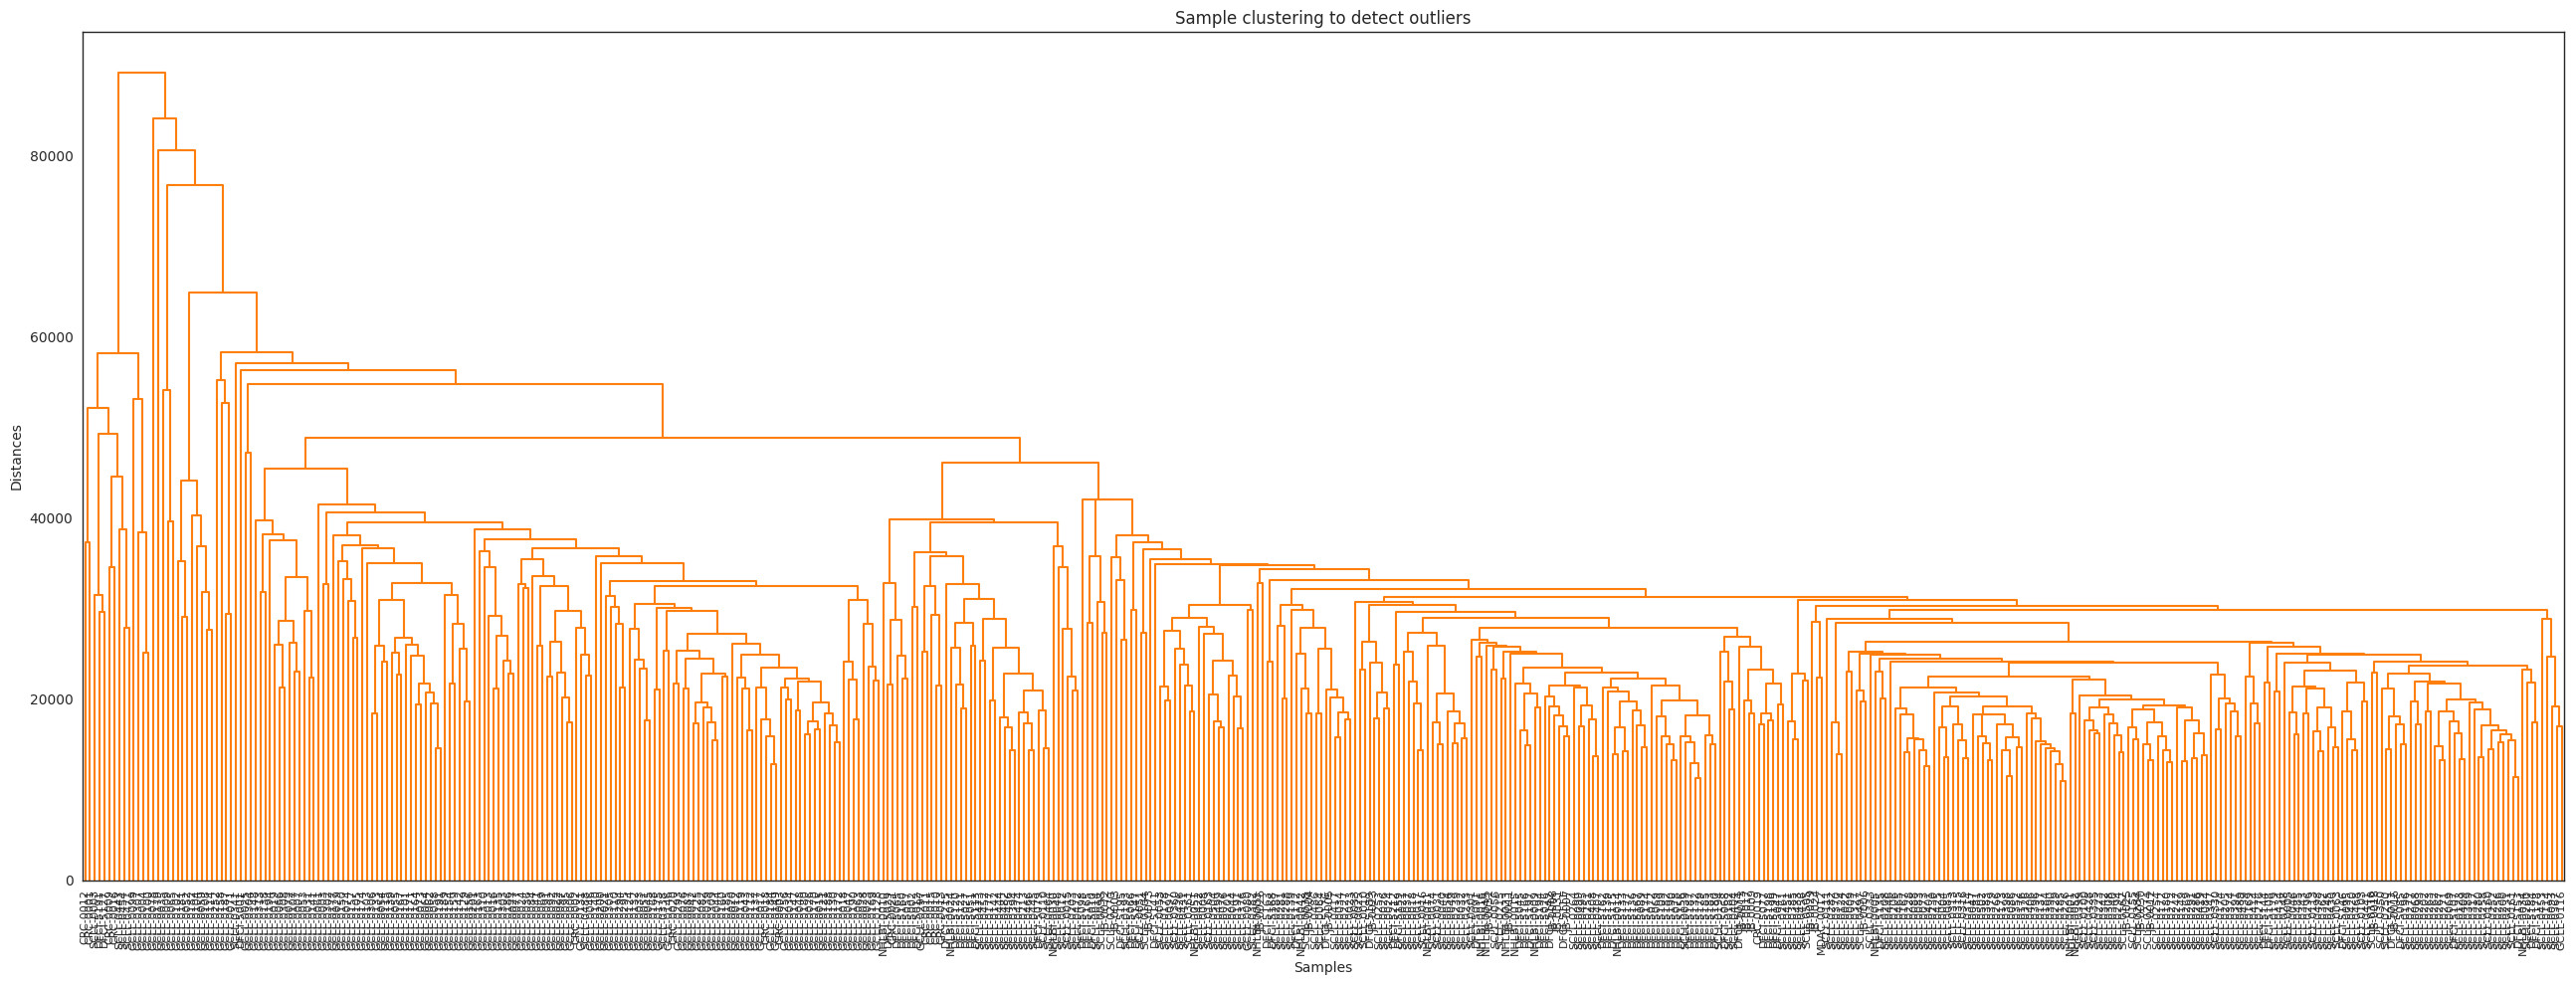

In [109]:
pyWGCNA_reprog = PyWGCNA.WGCNA(name='rnaseq_adults',
                               species='homo sapiens',
                               geneExp=data_for_wgcna,
                               outputPath='wgcna_',
                               TPMcutoff=0,
                               save=True)
pyWGCNA_reprog.geneExpr.to_df()

pyWGCNA_reprog.preprocess()

Run WGCNA...
pickSoftThreshold: calculating connectivity for given powers...
will use block size  1774


    Power  SFT.R.sq     slope truncated R.sq      mean(k)    median(k)  \
0       1  0.084218 -0.167459       0.234581  4714.742215  4806.901816   
1       2  0.577444 -0.805048       0.738818  1840.064508  1550.699114   
2       3   0.68204 -1.133333       0.830609   875.697439   593.242988   
3       4  0.727344 -1.317727       0.876171   469.487287   257.304271   
4       5  0.746985 -1.441786       0.898145   272.841529   124.208368   
5       6   0.77244 -1.508537       0.923588   168.151068    64.921636   
6       7  0.790722 -1.561127       0.940229   108.399368    35.397135   
7       8  0.803303 -1.603613        0.94902    72.425438    19.656997   
8       9  0.805433 -1.642754       0.953956    49.827819    11.308708   
9      10  0.817335 -1.662987       0.962622    35.131927     6.661137   
10     11   0.82738 -1.670591       0.971233    25.294141     3.992577   
11     13  0.852817 -1.681922       0.985393    13.814576     1.556365   
12     15  0.862641 -1.697342       0.

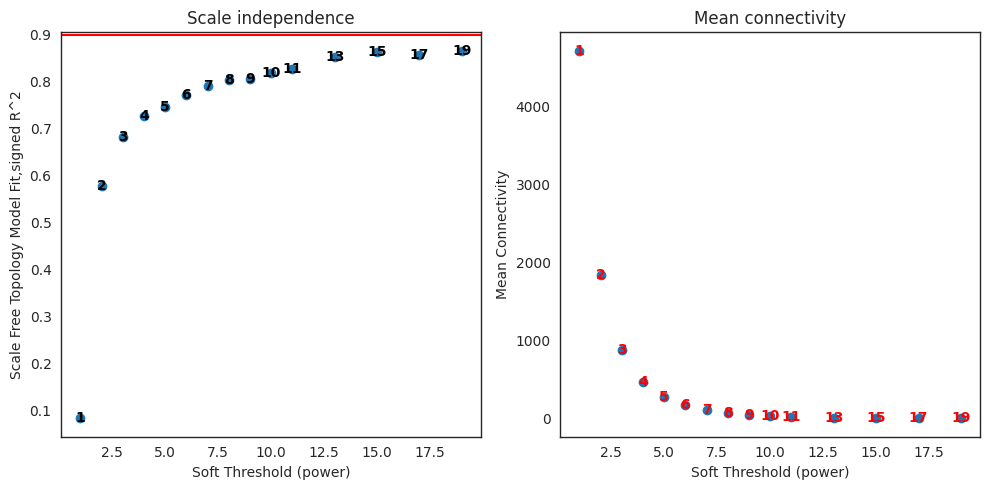

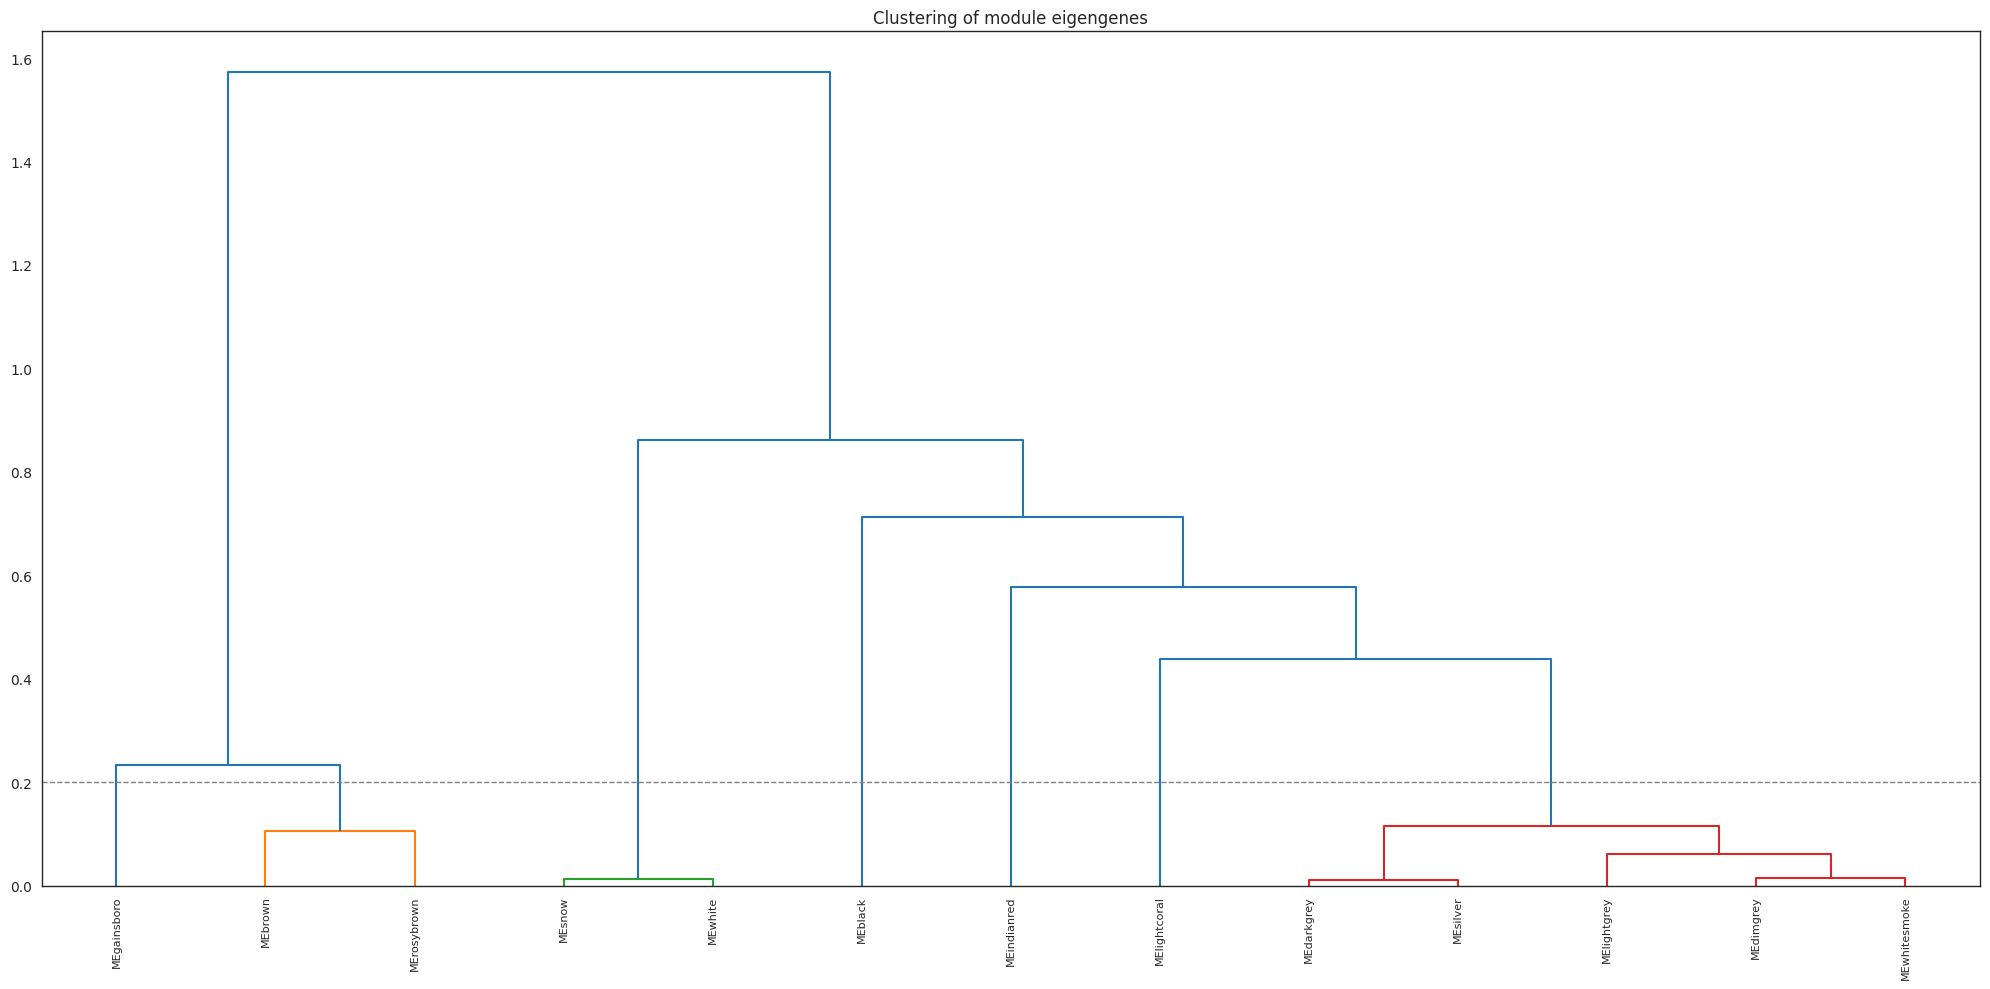

In [111]:
pyWGCNA_reprog.findModules()

In [112]:
pyWGCNA_reprog.saveWGCNA()

Saving WGCNA as rnaseq_adults.p


In [ ]:
X_train_wgcna = pyWGCNA_reprog.MEs

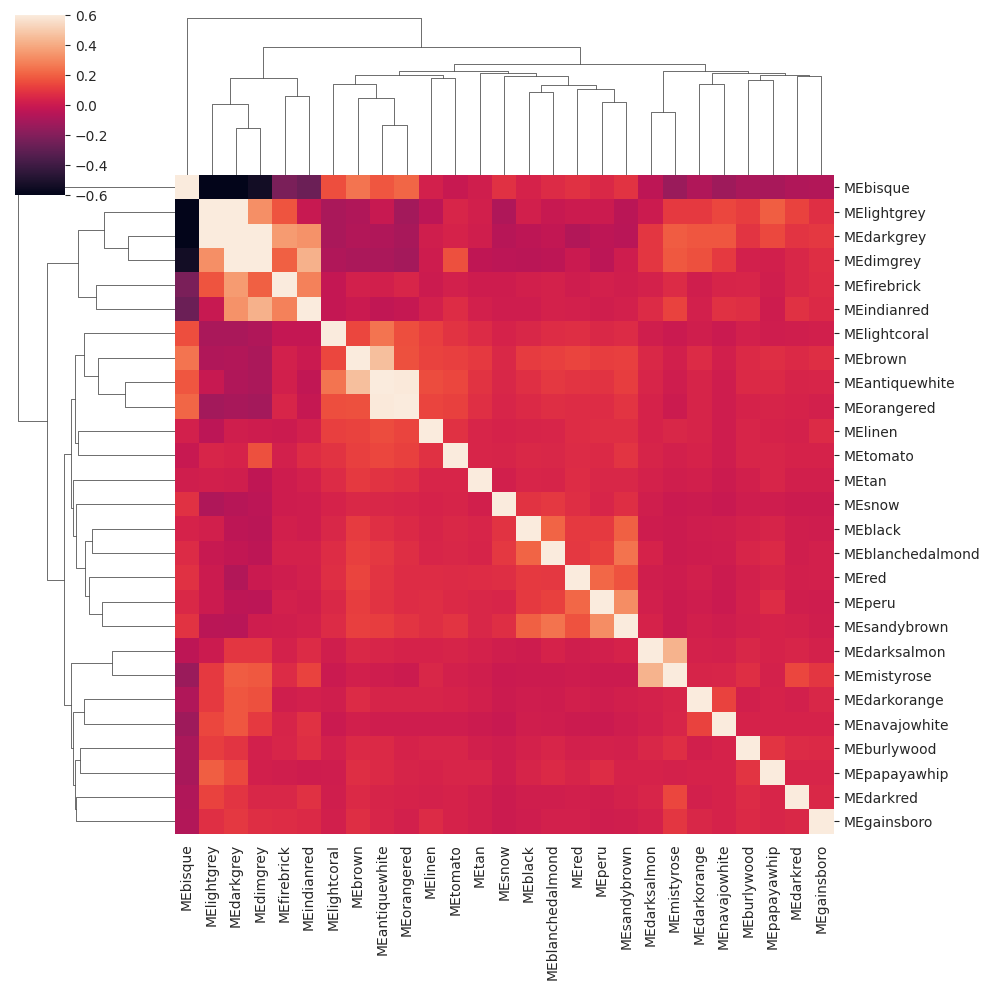

In [51]:
sns.clustermap(X_train_wgcna.corr(), vmin=-0.6, vmax=0.6)

In [56]:
Cox_wgcna_train = pd.concat([X_train_wgcna, 
                             y_train.loc[X_train_wgcna.index]], axis=1)
cph_wgcna = CoxPHFitter(penalizer=1)
cph_wgcna.fit(Cox_wgcna_train, duration_col = "event_time", event_col = "event")

<lifelines.CoxPHFitter: fitted with 513 total observations, 351 right-censored observations>

In [ ]:
print(cph_wgcna.score(Cox_wgcna_train, scoring_method="concordance_index"))

0.6176438829500054


# Small WGCNA

Saving data to be True, checking requirements ...
Pre-processing...
	Detecting genes and samples with too many missing values...
	Done pre-processing..



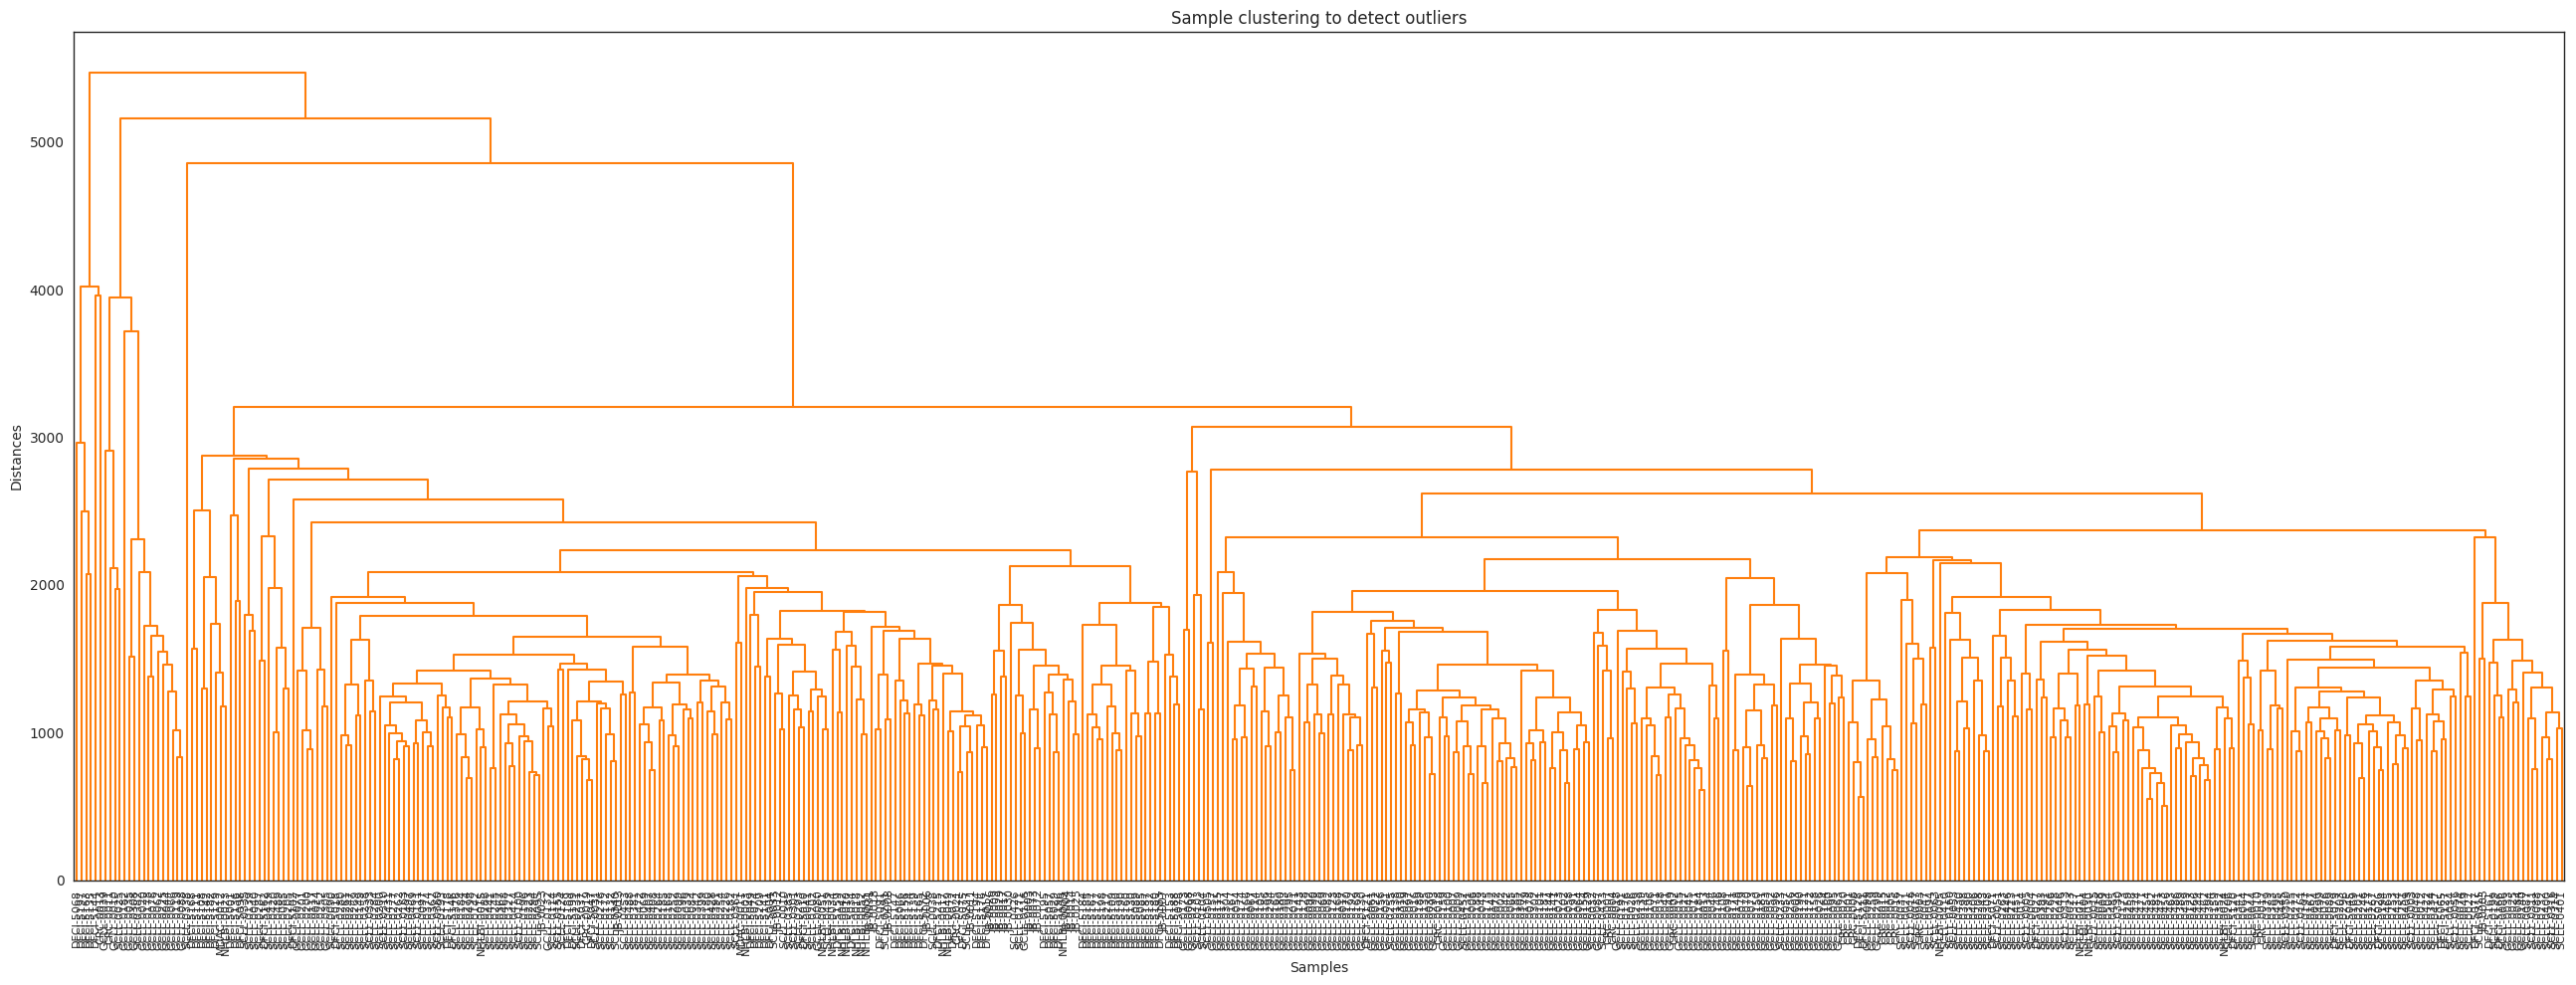

In [61]:
pyWGCNA_reprog = PyWGCNA.WGCNA(name='rnaseq_adults_small',
                               species='homo sapiens',
                               geneExp=X_train_small[rnaseq_small.covariate],
                               outputPath='wgcna_',
                               TPMcutoff=0,
                               save=True)
pyWGCNA_reprog.geneExpr.to_df()

pyWGCNA_reprog.preprocess()

In [103]:
samples_to_drop = ["DFCI-5068", "DFCI-5132", "GCLL-0039", "CRC-0011", "GCLL-0010", "SCLL-0025", "CRC-0013", "DFCI-5144", "DFCI-5197", "DFCI-5168", "DFCI-5163", "DFCI-5135", "SCLL-0338"]

data_for_wgcna_small = X_train_small[rnaseq_small.covariate].drop(samples_to_drop)

In [82]:
X_train_small.reset_index(names="sample_id").sample_id.str[:4].unique()

array(['GCLL', 'SCLL', 'CRC-', 'DFCI', 'JB-0', 'NHLB', 'MDAC'],
      dtype=object)

Saving data to be True, checking requirements ...
Pre-processing...
	Detecting genes and samples with too many missing values...


	Done pre-processing..



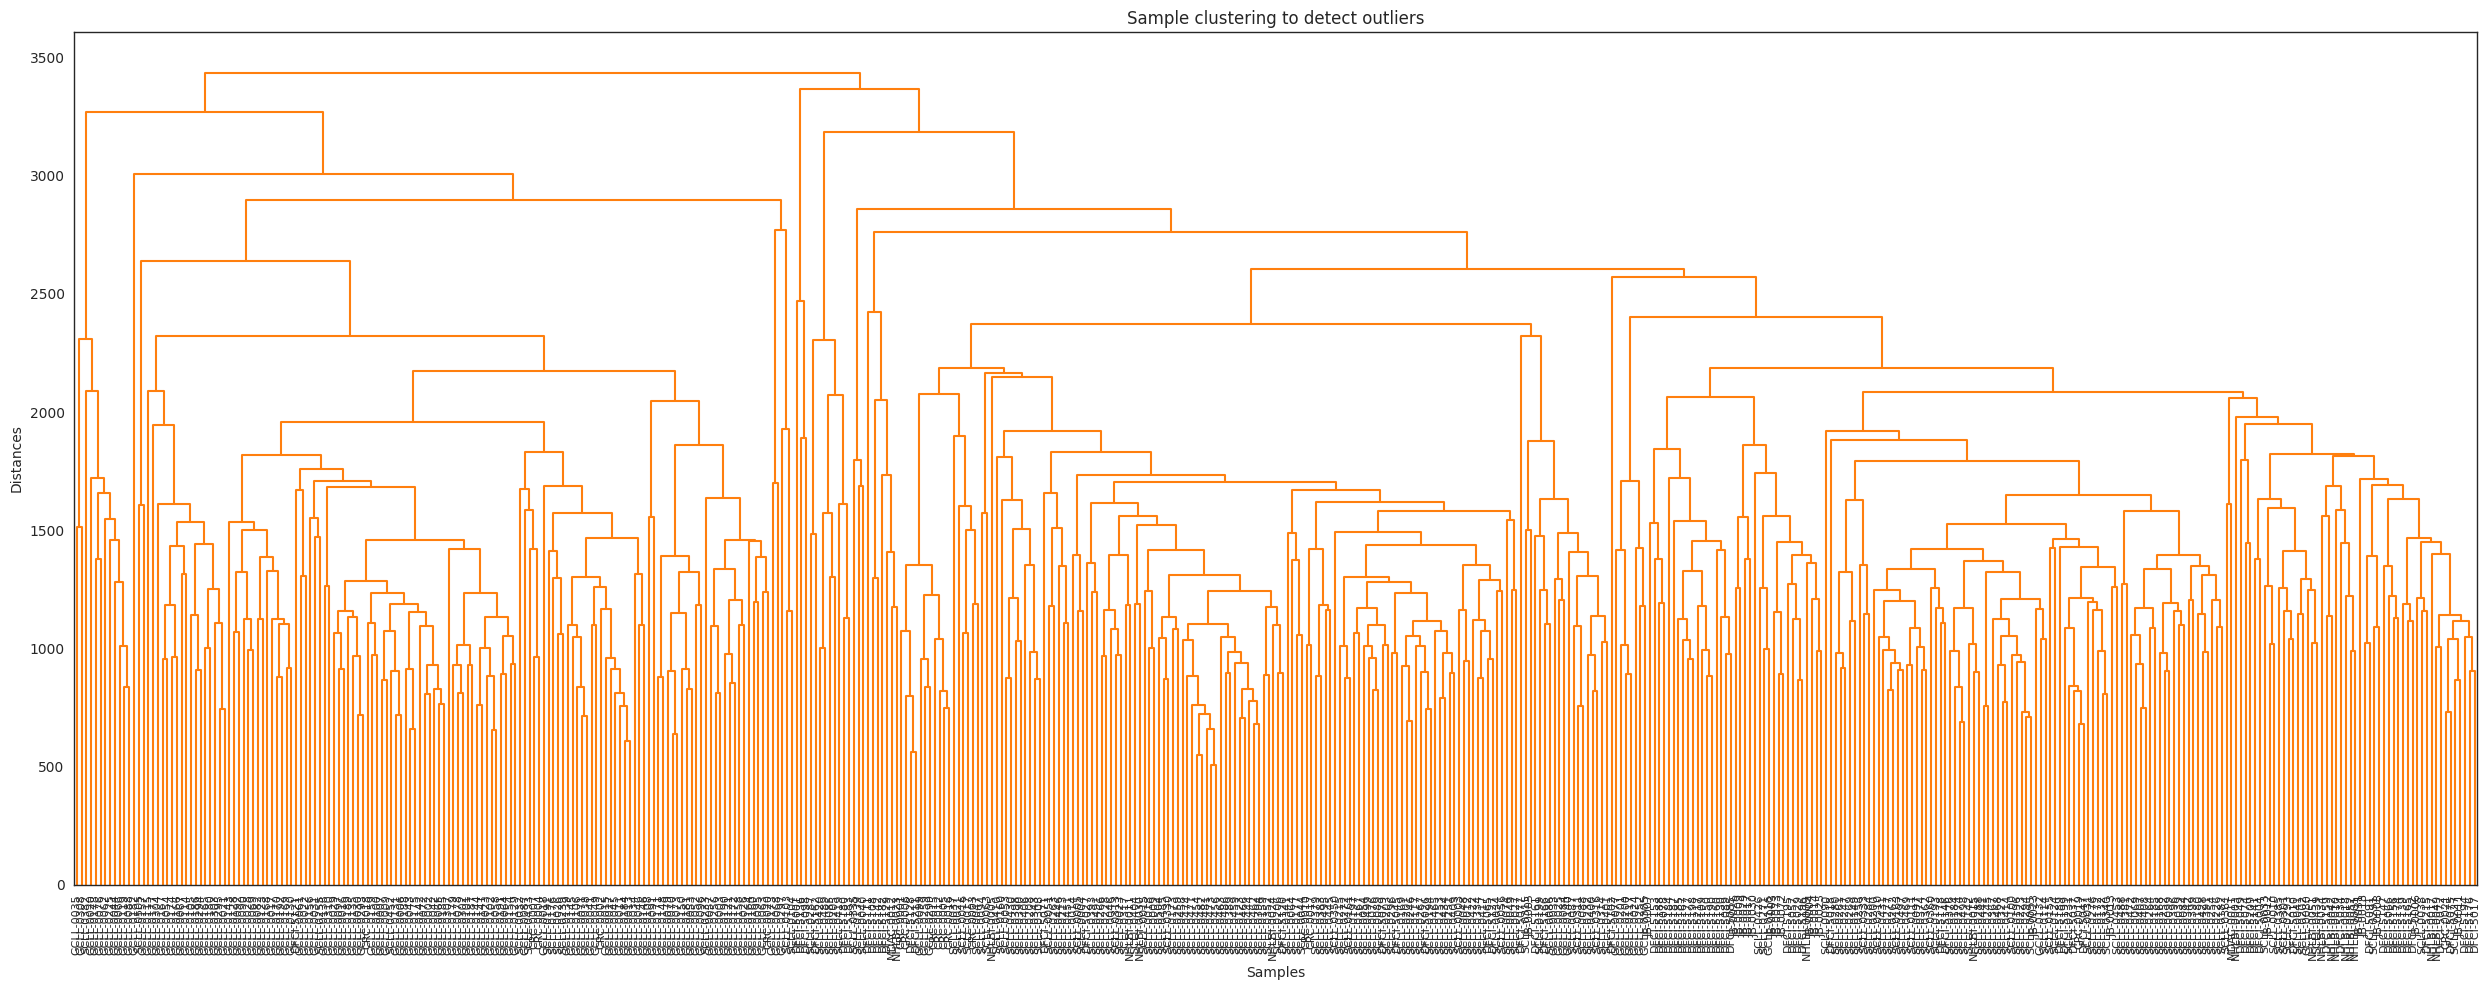

In [107]:
pyWGCNA_reprog = PyWGCNA.WGCNA(name='rnaseq_adults_small',
                               species='homo sapiens',
                               geneExp=data_for_wgcna_small,
                               outputPath='wgcna_',
                               TPMcutoff=0,
                               powers=np.arange(1, 26),
                               save=True)
pyWGCNA_reprog.geneExpr.to_df()

pyWGCNA_reprog.preprocess()

Run WGCNA...
pickSoftThreshold: calculating connectivity for given powers...
will use block size  1386
    Power  SFT.R.sq     slope truncated R.sq     mean(k)   median(k)  \
0       1  0.012916  0.111102      -0.016174    371.0539  442.007287   
1       2  0.062488 -0.213167      -0.202269   181.40532  211.935481   
2       3  0.253656 -0.307156       0.044798  103.738412  112.113951   
3       4   0.39925 -0.526306       0.411332   65.132645   63.801063   
4       5  0.499791  -0.75421       0.663794   43.523033   37.994206   
5       6  0.574564 -0.917165        0.79707   30.406186   23.833899   
6       7  0.639036 -1.073791       0.861296    21.96612   15.303386   
7       8  0.680983 -1.212206       0.906508   16.292518    9.781869   
8       9  0.716993  -1.27319       0.936667   12.346665    6.355932   
9      10  0.745449  -1.33413       0.948335     9.52645    4.231663   
10     11  0.769684 -1.376041       0.962345    7.464792    2.869907   
11     12  0.796044 -1.397525    

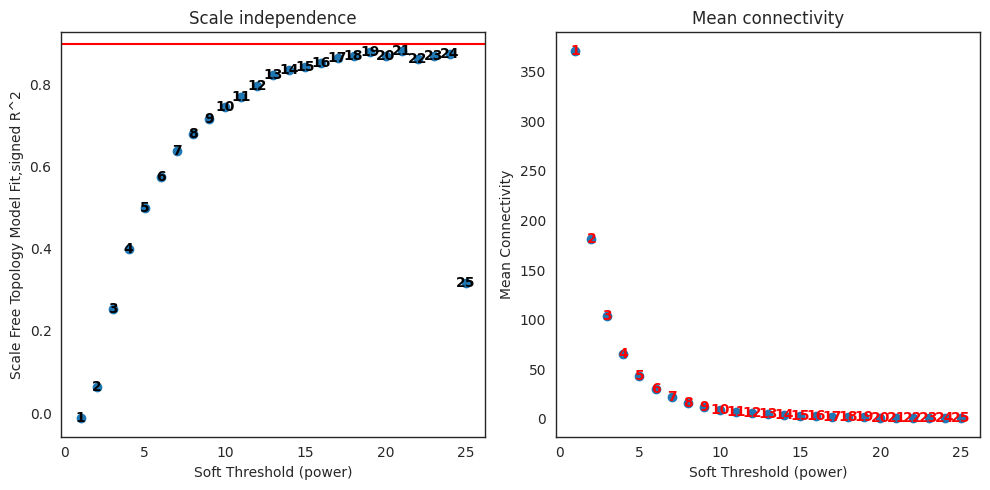

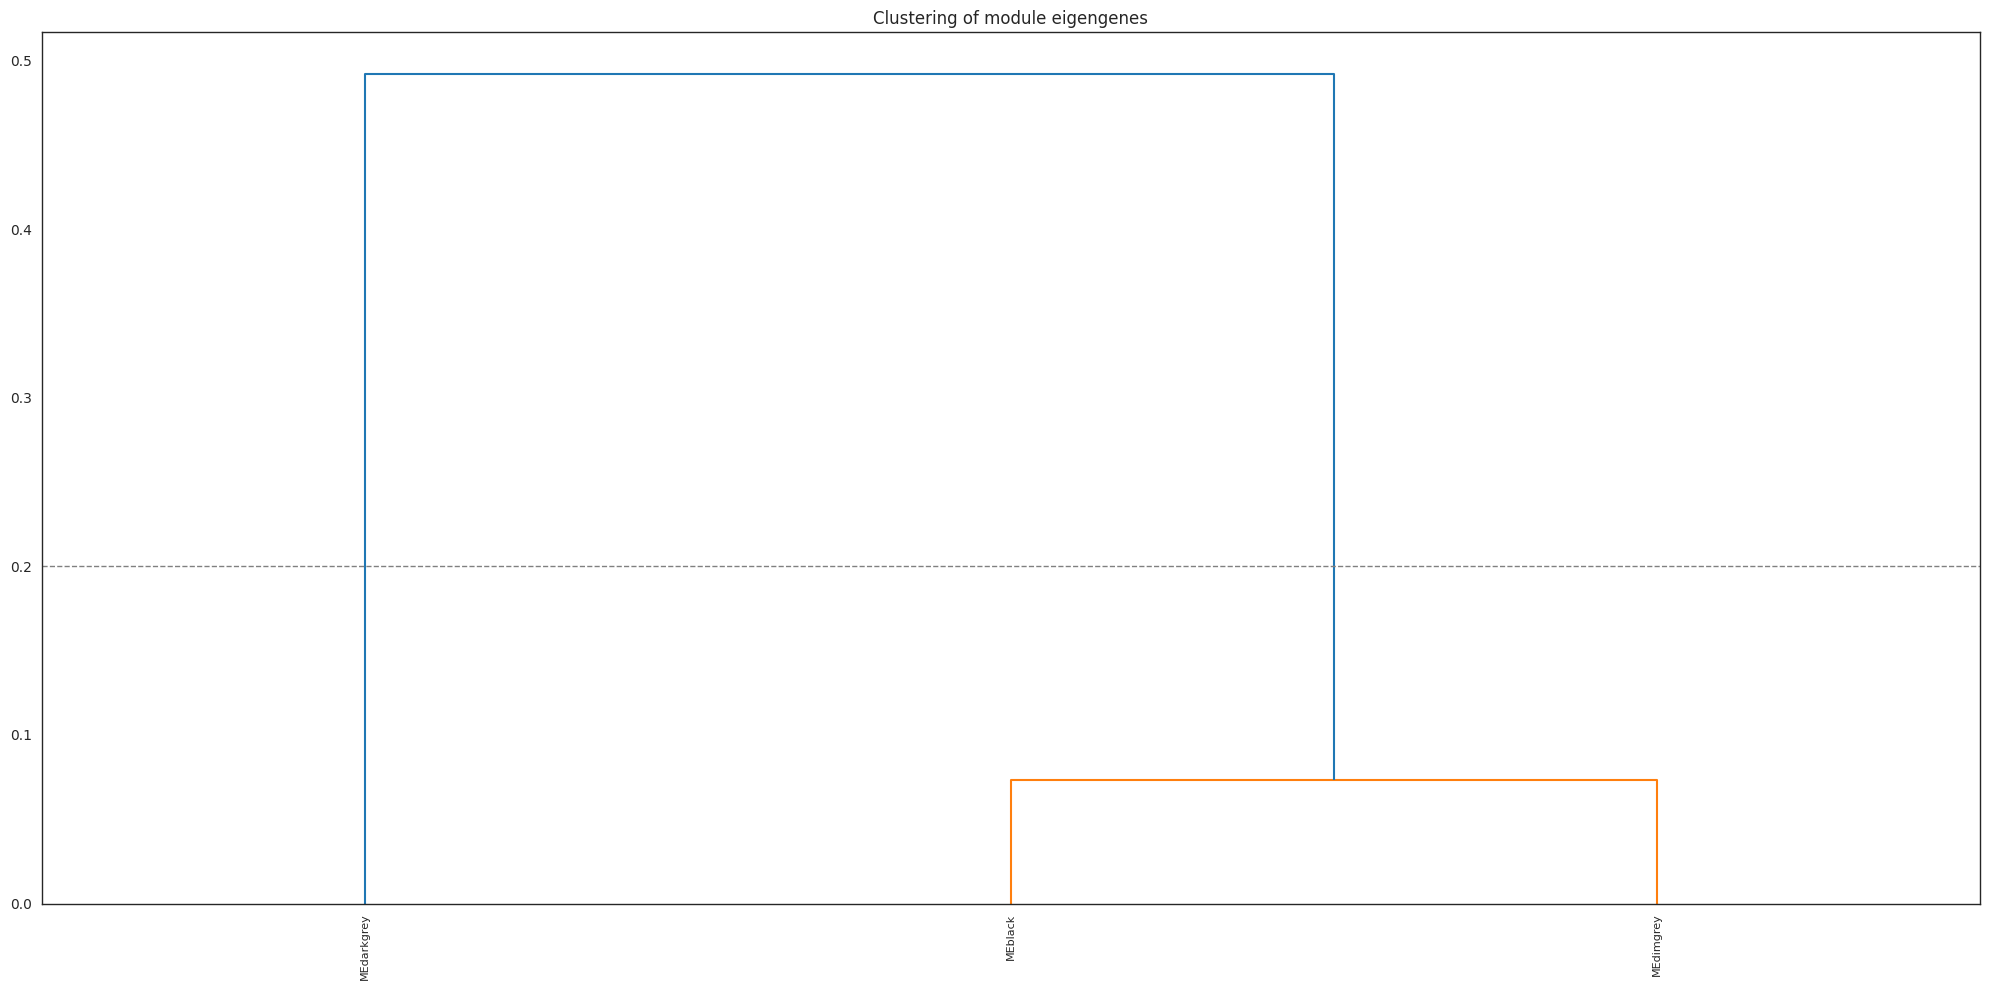

In [108]:
pyWGCNA_reprog.findModules()

In [89]:
pyWGCNA_reprog.saveWGCNA()

Saving WGCNA as rnaseq_adults_small.p


In [109]:
X_train_wgcna_small = pyWGCNA_reprog.MEs

In [110]:
Cox_wgcna_train = pd.concat([X_train_wgcna_small, 
                             y_train.loc[X_train_wgcna_small.index]], axis=1)
cph_wgcna = CoxPHFitter(penalizer=1)
cph_wgcna.fit(Cox_wgcna_train, duration_col = "event_time", event_col = "event")
print(cph_wgcna.score(Cox_wgcna_train, scoring_method="concordance_index"))

0.5792996625546274


# PCA

In [56]:
def calculate_pca(X_train_pca, X_val_pca, y_train, y_val, n_components, X_test_pca=None, y_test=None, debugging=False, **kwargs):
    X_train_pca_df = pd.DataFrame(X_train_pca[:, :n_components],
                                        columns=[f'PC{i+1}' for i in range(n_components)],
                                        index=y_train.index)
    X_val_pca_df = pd.DataFrame(X_val_pca[:, :n_components],
                                    columns=[f'PC{i+1}' for i in range(n_components)],
                                    index=y_val.index)
    
    
    Cox_train = pd.concat([X_train_pca_df, y_train], axis=1)
    Cox_val = pd.concat([X_val_pca_df, y_val], axis=1)

    if not debugging:
        try:
            cox = CoxPHFitter(**kwargs)
            cox.fit(Cox_train, duration_col='event_time', event_col='event')

            train_ci = cox.score(Cox_train, scoring_method="concordance_index")
            val_ci = cox.score(Cox_val, scoring_method="concordance_index")

            if X_test_pca is not None and y_test is not None:
                X_test_pca_df = pd.DataFrame(X_test_pca[:, :n_components],
                                    columns=[f'PC{i+1}' for i in range(n_components)],
                                    index=y_test.index)
                Cox_test = pd.concat([X_test_pca_df, y_test], axis=1)
                test_ci = cox.score(Cox_test, scoring_method="concordance_index")

                return cox, train_ci, val_ci, test_ci
            return cox, train_ci, val_ci
        except:
            print("There was an error")
            if X_test_pca is not None and y_test is not None:
                return None, 0, 0, 0
            return None, 0, 0
    else:
        cox = CoxPHFitter(**kwargs)
        cox.fit(Cox_train, duration_col='event_time', event_col='event')

        train_ci = cox.score(Cox_train, scoring_method="concordance_index")
        val_ci = cox.score(Cox_val, scoring_method="concordance_index")

        if X_test_pca is not None and y_test is not None:
            X_test_pca_df = pd.DataFrame(X_test_pca[:, :n_components],
                                    columns=[f'PC{i+1}' for i in range(n_components)],
                                    index=y_test.index)
            Cox_test = pd.concat([X_test_pca_df, y_test], axis=1)
            test_ci = cox.score(Cox_test, scoring_method="concordance_index")


            return cox, train_ci, val_ci, test_ci
        return cox, train_ci, val_ci
    
def n_conponents_search(X_train_pca, X_val_pca, y_train, y_val, n_max=200):
    cindex_results_val= []
    valid_comps_arr = []

    for n_components in tqdm(range(1, n_max)):
        cox, train_ci, val_ci = calculate_pca(X_train_pca, X_val_pca, y_train, y_val, n_components)

        if cox is not None:
            cindex_results_val.append(val_ci)
            valid_comps_arr.append(n_components)

    return cindex_results_val, valid_comps_arr

In [27]:
def calculate_importances_table(cox, pca, features):
    components = [int(comp[2:]) - 1 for comp in cox.summary[cox.summary.p < 0.05].index]
    print(f"{components} PCs are used")

    cox_coef = cox.params_.values[components]
    pca_loadings = pca.components_[components].T

    original_importance = pca_loadings @ cox_coef

    importance_df = pd.DataFrame(
        {
            "feature": features,
            "importance": original_importance
        }
    ).sort_values("importance", key=np.abs, ascending=False)

    return importance_df

In [28]:
def gsea_enrichment(importances):
    res_h = gp.prerank(
        rnk=importances,
        gene_sets="MSigDB_Hallmark_2020",
        permutation_num=2000,
        min_size=10,
        max_size=500,
        seed=42,
        outdir="gsea_hallmark",
        verbose=True,
    )

    res_kegg = gp.prerank(
        rnk=importances,
        gene_sets="KEGG_2021_Human",
        permutation_num=2000,
        min_size=10,
        max_size=500,
        seed=42,
        outdir="gsea_kegg",
    )

    res_go = gp.prerank(
        rnk=importances,
        gene_sets="GO_Biological_Process_2023",
        permutation_num=2000,
        min_size=10,
        max_size=500,
        seed=42,
        outdir="gsea_go_bp",
    )

    return res_h, res_kegg, res_go

## Full gene list

In [30]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled   = scaler.transform(X_val)
X_test_scaled   = scaler.transform(X_test)

pca_full = PCA(n_components=400, random_state=42)
X_train_pca = pca_full.fit_transform(X_train_scaled)
X_val_pca   = pca_full.transform(X_val_scaled)
X_test_pca   = pca_full.transform(X_test_scaled)


### Grid Search on the non-penalized Cox

100%|██████████| 199/199 [01:56<00:00,  1.71it/s]


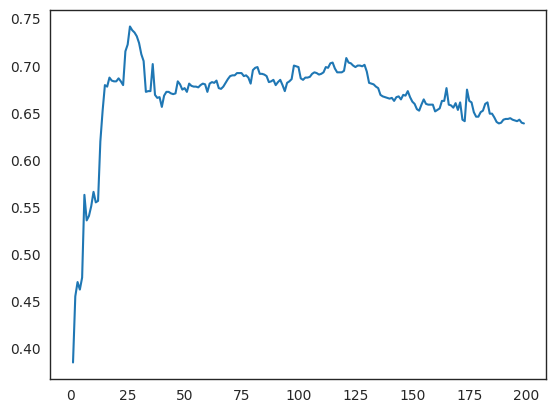

In [31]:
cindex_results_val, valid_comps_arr = n_conponents_search(X_train_pca, X_val_pca, y_train, y_val)
n_opt = valid_comps_arr[np.argmax(cindex_results_val)]

plt.plot(valid_comps_arr, cindex_results_val)

In [63]:
cox_full, train_ci, val_ci, test_ci = calculate_pca(X_train_pca, X_val_pca, y_train, y_val, n_opt, X_test_pca, y_test)
val_ci

np.float64(0.7416267942583732)

### Optuna on the penalized Cox

In [33]:
def objective(trial):
    n_components = trial.suggest_int("n_components", 1, 400)
    penalizer = trial.suggest_float("penalizer", 1e-6, 1.0, log=True)

    _, _, val_ci = calculate_pca(X_train_pca, X_val_pca, y_train, y_val, n_components, penalizer=penalizer)

    return val_ci

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=200, show_progress_bar=True)

[I 2025-12-17 21:52:27,630] A new study created in memory with name: no-name-f4e2d113-bb48-42c0-9516-9987d4a9fe89


  0%|          | 0/200 [00:00<?, ?it/s]

[I 2025-12-17 21:52:29,868] Trial 0 finished with value: 0.6889952153110048 and parameters: {'n_components': 259, 'penalizer': 9.645993475516177e-06}. Best is trial 0 with value: 0.6889952153110048.
[I 2025-12-17 21:52:37,523] Trial 1 finished with value: 0.751993620414673 and parameters: {'n_components': 400, 'penalizer': 0.00021752227937047022}. Best is trial 1 with value: 0.751993620414673.
[I 2025-12-17 21:52:43,243] Trial 2 finished with value: 0.7256778309409888 and parameters: {'n_components': 395, 'penalizer': 0.002282499932537711}. Best is trial 1 with value: 0.751993620414673.
[I 2025-12-17 21:52:45,135] Trial 3 finished with value: 0.7511961722488039 and parameters: {'n_components': 337, 'penalizer': 0.31659729564444095}. Best is trial 1 with value: 0.751993620414673.
[I 2025-12-17 21:52:45,846] Trial 4 finished with value: 0.7025518341307815 and parameters: {'n_components': 128, 'penalizer': 3.694326021784335e-05}. Best is trial 1 with value: 0.751993620414673.
[I 2025-12-1

In [34]:
study.best_params

{'n_components': 363, 'penalizer': 0.0035724466576148683}

In [64]:
n_components = 363
penalizer = 0.0035724466576148683

cox_full_penalized, _, val_ci, test_ci = calculate_pca(X_train_pca, X_val_pca, y_train, y_val, X_test_pca=X_test_pca, y_test=y_test, n_components=n_components, penalizer=penalizer)
val_ci

np.float64(0.7966507177033493)

### Gene importances on the best result model

In [255]:
cox_full_best, _, val_ci, test_ci = calculate_pca(X_train_pca, X_val_pca, y_train, y_val, X_test_pca=X_test_pca, y_test=y_test, n_components=n_components, penalizer=penalizer)
val_ci, test_ci

(np.float64(0.7966507177033493), np.float64(0.691108545034642))

In [256]:
importances_full = calculate_importances_table(cox_full_best, pca_full, X_train.columns)
importances_full = importances_full[np.abs(importances_full.importance) > 0]

importances_full.shape

[0, 2, 6, 8, 12, 14, 19, 22, 24, 31, 35, 39, 81, 94, 115, 119, 120, 158, 172, 173, 202, 327, 336, 345, 352, 359, 361] PCs are used


(45344, 2)

In [257]:
res_h_full, res_kegg_full, res_go_full = gsea_enrichment(importances_full)

2025-12-18 01:03:50,884 [WARNING] Duplicated values found in preranked stats: 0.01% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


2025-12-18 01:03:50,885 [INFO] Parsing data files for GSEA.............................
2025-12-18 01:03:51,015 [INFO] Enrichr library gene sets already downloaded in: /home/epifantsevst/.cache/gseapy, use local file
2025-12-18 01:03:51,041 [INFO] 0000 gene_sets have been filtered out when max_size=500 and min_size=10
2025-12-18 01:03:51,043 [INFO] 0050 gene_sets used for further statistical testing.....
2025-12-18 01:03:51,044 [INFO] Start to run GSEA...Might take a while..................
2025-12-18 01:04:16,428 [INFO] Congratulations. GSEApy runs successfully................

2025-12-18 01:04:16,515 [WARNING] Duplicated values found in preranked stats: 0.01% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2025-12-18 01:05:25,314 [WARNING] Duplicated values found in preranked stats: 0.01% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


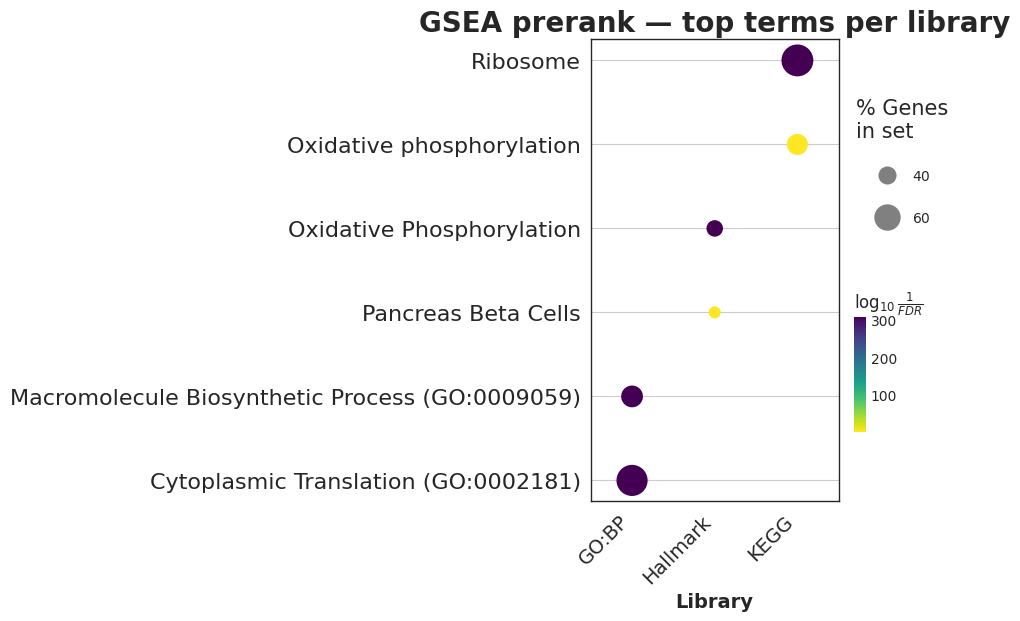

In [263]:
def add_lib(res, lib):
    df = res.res2d.copy()
    df["Library"] = lib
    return df

plot_df = pd.concat([
    add_lib(res_h_full, "Hallmark"),
    add_lib(res_kegg_full, "KEGG"),
    add_lib(res_go_full, "GO:BP"),
], ignore_index=True)

plot_df = (plot_df.sort_values("FDR q-val")
           .groupby("Library", group_keys=False)
           .head(10))

gp.dotplot(plot_df,
        x="Library",
        column="FDR q-val",
        cutoff=0.25,
        top_term=2,
        title="GSEA prerank — top terms per library",
        xticklabels_rot=45)
plt.show()

In [259]:
for res in [res_h_full, res_kegg_full, res_go_full]:
    print(res.res2d[res.res2d["FDR q-val"] < 0.05])

      Name                       Term        ES       NES NOM p-val FDR q-val  \
0  prerank  Oxidative Phosphorylation  0.483634  2.170064       0.0       0.0   
1  prerank        Pancreas Beta Cells  0.560315  1.851754       0.0  0.001289   
3  prerank                p53 Pathway   0.34881  1.563757       0.0  0.041243   

  FWER p-val   Tag %  Gene %  \
0        0.0  73/184  22.61%   
1      0.002    9/31  16.82%   
3     0.1195  74/190  27.61%   

                                          Lead_genes  
0  MRPS15;UQCRFS1;SLC25A6;ETFA;MPC1;SLC25A5;CPT1A...  
1  VDR;ABCC8;SRP14;INSM1;SEC11A;SRPRB;DPP4;SLC2A2...  
3  VDR;CTSF;DDIT4;PITPNC1;RNF19B;SESN1;AEN;GADD45...  
      Name                       Term        ES       NES NOM p-val FDR q-val  \
0  prerank                   Ribosome  0.595349  2.558412       0.0       0.0   
1  prerank  Oxidative phosphorylation   0.49019  2.010526       0.0  0.004554   
2  prerank        Coronavirus disease  0.430702  1.977458       0.0  0.006306   
3 

## Smaller gene set

In [115]:
scaler_small = StandardScaler()
X_train_scaled_small = scaler_small.fit_transform(X_train_small)
X_val_scaled_small = scaler_small.transform(X_val_small)
X_test_scaled_small = scaler_small.transform(X_test_small)

pca_small = PCA(n_components=400, random_state=42)
X_train_pca_small = pca_small.fit_transform(X_train_scaled_small)
X_val_pca_small = pca_small.transform(X_val_scaled_small)
X_test_pca_small = pca_small.transform(X_test_scaled_small)

### Grid Search on the non-penalized Cox

100%|██████████| 199/199 [01:54<00:00,  1.74it/s]


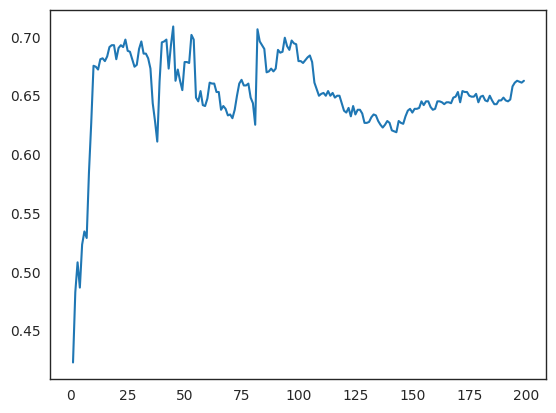

In [117]:
cindex_results_val, valid_comps_arr = n_conponents_search(X_train_pca_small, X_val_pca_small, y_train, y_val)
n_opt = valid_comps_arr[np.argmax(cindex_results_val)]

plt.plot(valid_comps_arr, cindex_results_val)

In [118]:
cox_small, train_ci, val_ci, test_ci = calculate_pca(X_train_pca_small, X_val_pca_small, y_train, y_val, n_opt, X_test_pca_small, y_test)
val_ci, test_ci

(np.float64(0.7089314194577353), np.float64(0.6824480369515011))

### Optuna on the penalized Cox

In [119]:
def objective(trial):
    n_components = trial.suggest_int("n_components", 1, 400)
    penalizer = trial.suggest_float("penalizer", 1e-6, 1.0, log=True)

    _, _, val_ci = calculate_pca(X_train_pca_small, X_val_pca_small, y_train, y_val, n_components, penalizer=penalizer)

    return val_ci

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=200, show_progress_bar=True)

[I 2025-12-17 23:16:04,683] A new study created in memory with name: no-name-8fcc2da6-b4bc-43e3-bdbd-e49717eddf35


  0%|          | 0/200 [00:00<?, ?it/s]

[I 2025-12-17 23:16:11,391] Trial 0 finished with value: 0.740829346092504 and parameters: {'n_components': 348, 'penalizer': 0.0005312008598270262}. Best is trial 0 with value: 0.740829346092504.
[I 2025-12-17 23:16:13,016] Trial 1 finished with value: 0.6355661881977671 and parameters: {'n_components': 235, 'penalizer': 0.01041930019265749}. Best is trial 0 with value: 0.740829346092504.
[I 2025-12-17 23:16:17,381] Trial 2 finished with value: 0.7256778309409888 and parameters: {'n_components': 279, 'penalizer': 3.3046399040434977e-06}. Best is trial 0 with value: 0.740829346092504.
[I 2025-12-17 23:16:18,922] Trial 3 finished with value: 0.6953748006379585 and parameters: {'n_components': 339, 'penalizer': 0.36617927604535705}. Best is trial 0 with value: 0.740829346092504.
[I 2025-12-17 23:16:20,143] Trial 4 finished with value: 0.682615629984051 and parameters: {'n_components': 198, 'penalizer': 0.0011025759214206498}. Best is trial 0 with value: 0.740829346092504.
[I 2025-12-17 2

In [120]:
study.best_params

{'n_components': 340, 'penalizer': 0.000314211422271942}

In [122]:
n_components = 340
penalizer = 0.000314211422271942

cox_small_penalized, _, val_ci, test_ci = calculate_pca(X_train_pca_small, X_val_pca_small, y_train, y_val, X_test_pca=X_test_pca_small, y_test=y_test, 
                                                        n_components=n_components, penalizer=penalizer)
val_ci, test_ci

(np.float64(0.7838915470494418), np.float64(0.6830254041570438))

### Imprtances on the best result model

In [124]:
cox_small_best, train_ci, val_ci, test_ci = calculate_pca(X_train_pca_small, X_val_pca_small, y_train, y_val, X_test_pca=X_test_pca_small, y_test=y_test, 
                                                        n_components=n_components, penalizer=penalizer)
val_ci, test_ci

(np.float64(0.7838915470494418), np.float64(0.6830254041570438))

In [126]:
importances_small = calculate_importances_table(cox_small_best, pca_small, X_train_small.columns)
importances_small = importances_small[np.abs(importances_small.importance) > 0]

importances_small.shape

[2, 4, 6, 9, 15, 20, 21, 27, 30, 43, 45, 56, 64, 85] PCs are used


(13419, 2)

In [127]:
res_h_small, res_kegg_small, res_go_small = gsea_enrichment(importances_small)

2025-12-17 23:32:40,126 [INFO] Parsing data files for GSEA.............................
2025-12-17 23:32:40,184 [INFO] Enrichr library gene sets already downloaded in: /home/epifantsevst/.cache/gseapy, use local file
2025-12-17 23:32:40,203 [INFO] 0001 gene_sets have been filtered out when max_size=500 and min_size=10
2025-12-17 23:32:40,204 [INFO] 0049 gene_sets used for further statistical testing.....
2025-12-17 23:32:40,205 [INFO] Start to run GSEA...Might take a while..................
2025-12-17 23:32:44,667 [INFO] Congratulations. GSEApy runs successfully................



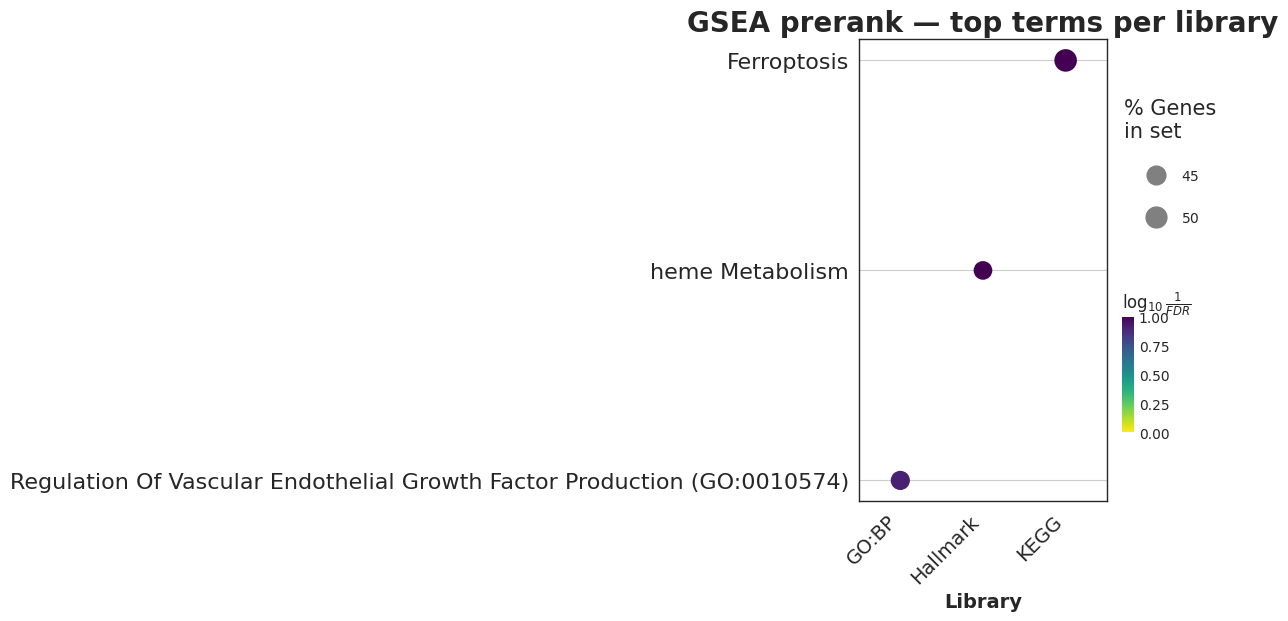

In [266]:
def add_lib(res, lib):
    df = res.res2d.copy()
    df["Library"] = lib
    return df

plot_df = pd.concat([
    add_lib(res_h_small, "Hallmark"),
    add_lib(res_kegg_small, "KEGG"),
    add_lib(res_go_small, "GO:BP"),
], ignore_index=True)

plot_df = (plot_df.sort_values("FDR q-val")
           .groupby("Library", group_keys=False)
           .head(10))

gp.dotplot(plot_df,
        x="Library",
        column="FDR q-val",
        cutoff=0.25,
        top_term=1,
        title="GSEA prerank — top terms per library",
        xticklabels_rot=45)
plt.show()

In [265]:
for res in [res_h_small, res_kegg_small, res_go_small]:
    print(res.res2d[res.res2d["FDR q-val"] < 0.1])

      Name             Term        ES       NES NOM p-val FDR q-val  \
0  prerank  heme Metabolism  0.443887  1.715036  0.002009  0.062781   

  FWER p-val  Tag %  Gene %                                         Lead_genes  
0     0.0835  39/87  29.21%  TRIM58;HBD;SNCA;HBBP1;ALAS2;SELENBP1;XK;HBQ1;T...  
      Name         Term        ES       NES NOM p-val FDR q-val FWER p-val  \
0  prerank  Ferroptosis -0.576619 -1.939305  0.001416  0.057867       0.07   

   Tag %  Gene %                                         Lead_genes  
0  13/24  29.19%  SAT2;MAP1LC3A;TP53;GPX4;SLC3A2;GCLC;PRNP;SLC40...  
Empty DataFrame
Columns: [Name, Term, ES, NES, NOM p-val, FDR q-val, FWER p-val, Tag %, Gene %, Lead_genes]
Index: []


In [145]:
gene_list = importances_small.feature.to_list()

backgrounds = {"40k":rnaseq.index.tolist(), 
               "13k":rnaseq_small.index.tolist()}

for name, background in backgrounds.items():
    try:
        enr_h = gp.enrichr(
            gene_list=gene_list,
            gene_sets="MSigDB_Hallmark_2020",
            organism="Human",
            outdir=f"enrichr_hallmark_topN_{name}",
            cutoff=0.1,
            background = background      
        )
        print("Success")
    except:
        pass

    try:
        enr_kegg = gp.enrichr(
            gene_list=gene_list,
            gene_sets="KEGG_2021_Human",
            organism="Human",
            outdir=f"enrichr_kegg_topN_{name}",
            cutoff=0.1,
            background = background
        )
        print("Success")
    except:
        pass
    
    try:
        enr_reactome = gp.enrichr(
            gene_list=gene_list,
            gene_sets="Reactome_2022",
            organism="Human",
            outdir=f"enrichr_reactome_topN_{name}",
            cutoff=0.1,
            background = background
        )
        print("Success")
    except:
        pass

    try:   
        enr_go = gp.enrichr(
            gene_list=gene_list,
            gene_sets="GO_Biological_Process_2023",
            organism="Human",
            outdir=f"enrichr_go_bp_topN_{name}",
            cutoff=0.1,
            background = background
        )
        print("Success")
    except:
        pass

# Add patients data

In [ ]:
clin_data = pd.read_csv("processed_patients.csv", index_col=0)
cols_to_use = ['TMB_NONSYNONYMOUS',
              'COHORT_GCLLSG',
              'COHORT_UCSD',
              'TREATMENT_AFTER_SAMPLING_Chemo + Ab',
              'TREATMENT_AFTER_SAMPLING_Chemo + no Ab']

clin_data = clin_data.set_index("SAMPLE_ID")

clin_train_idx = list(set(X_train_small.index) & set(clin_data.index))
clin_val_idx = list(set(X_val_small.index) & set(clin_data.index))
clin_test_idx = list(set(X_test_small.index) & set(clin_data.index))



In [172]:
imputer = KNNImputer(weights="distance", n_neighbors=5)
clin_data_cols = clin_data.columns

clin_train = pd.DataFrame(imputer.fit_transform(clin_data.loc[clin_train_idx]), columns=clin_data_cols, index=clin_train_idx)[cols_to_use]
clin_val = pd.DataFrame(imputer.transform(clin_data.loc[clin_val_idx]), columns=clin_data_cols, index=clin_val_idx)[cols_to_use]
clin_test = pd.DataFrame(imputer.transform(clin_data.loc[clin_test_idx]), columns=clin_data_cols, index=clin_test_idx)[cols_to_use]

clin_train.shape, clin_val.shape, clin_test.shape

((389, 5), (67, 5), (76, 5))

## Use significant PCs from the previous trials

In [173]:
PCs_used = [2, 4, 6, 9, 15, 20, 21, 27, 30, 43, 45, 56, 64, 85]
PCs_used = [f"PC{i}" for i in PCs_used]

In [192]:
X_train_pca_clin_small = pd.concat([pd.DataFrame(X_train_pca_small, 
                                    index=X_train_small.index,
                                    columns = [f"PC{i + 1}" for i in range(X_train_pca_small.shape[1])]).loc[clin_train_idx], 
                                    clin_train], axis=1)
X_val_pca_clin_small = pd.concat([pd.DataFrame(X_val_pca_small, 
                                    index=X_val_small.index,
                                    columns = [f"PC{i + 1}" for i in range(X_val_pca_small.shape[1])]).loc[clin_val_idx], 
                                    clin_val], axis=1)
X_test_pca_clin_small = pd.concat([pd.DataFrame(X_test_pca_small, 
                                    index=X_test_small.index,
                                    columns = [f"PC{i + 1}" for i in range(X_test_pca_small.shape[1])]).loc[clin_test_idx], 
                                    clin_test], axis=1)

X_train_pca_clin_small.shape, X_val_pca_clin_small.shape, X_test_pca_clin_small.shape

((389, 405), (67, 405), (76, 405))

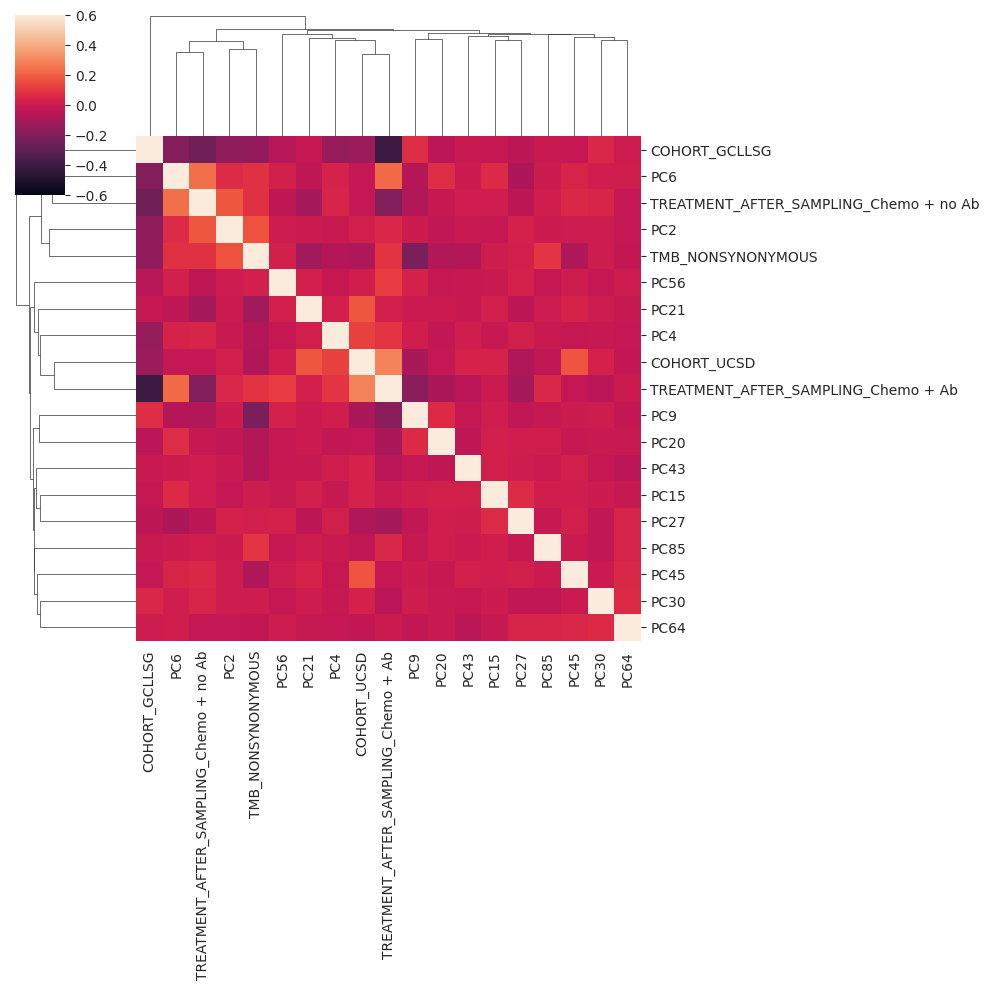

In [191]:
sns.clustermap(X_train_pca_clin_small[PCs_used + clin_val.columns.tolist()].corr(), vmin=-0.6, vmax=0.6)

In [ ]:
Cox_train_clin = pd.concat([X_train_pca_clin_small[PCs_used], 
                            y_train.loc[clin_train_idx]], axis=1)
Cox_val_clin = pd.concat([X_val_pca_clin_small[PCs_used], 
                            y_val.loc[clin_val_idx]], axis=1)
Cox_test_clin = pd.concat([X_test_pca_clin_small[PCs_used], 
                            y_test.loc[clin_test_idx]], axis=1)

cox_clin = CoxPHFitter()
cox_clin.fit(
    Cox_train_clin,
    duration_col='event_time',
    event_col='event'
)

train_ci_clin = cox_clin.score(
    Cox_train_clin,
    scoring_method="concordance_index"
)

val_ci_clin = cox_clin.score(
    Cox_val_clin,
    scoring_method="concordance_index"
)

test_ci_clin = cox_clin.score(
        Cox_test_clin,
        scoring_method="concordance_index"
    )

val_ci_clin, test_ci_clin

(np.float64(0.6121635094715853), np.float64(0.6153846153846154))

In [186]:
cols_rnaseq_clin_sign = cox_clin.summary[cox_clin.summary.p < 0.05].index

cox_clin.summary[cox_clin.summary.p < 0.05]

,coef,exp(coef),se(coef),coef lower 95%,coef upper 95%,exp(coef) lower 95%,exp(coef) upper 95%,cmp to,z,p,-log2(p)
covariate,,,,,,,,,,,
PC2,0.009968,1.010018,0.004364,0.001415,0.018520,1.001416,1.018693,0.0,2.284347,0.022351,5.483506
PC6,0.023052,1.023320,0.006982,0.009367,0.036738,1.009411,1.037421,0.0,3.301463,0.000962,10.021943
PC9,-0.018643,0.981530,0.006863,-0.032094,-0.005192,0.968415,0.994822,0.0,-2.716467,0.006598,7.243694
PC43,0.032033,1.032551,0.013384,0.005801,0.058265,1.005818,1.059995,0.0,2.393394,0.016693,5.904587
COHORT_GCLLSG,1.125328,3.081228,0.290079,0.556783,1.693873,1.745050,5.440511,0.0,3.879382,0.000105,13.221146
TREATMENT_AFTER_SAMPLING_Chemo + no Ab,0.709738,2.033459,0.335379,0.052407,1.367070,1.053804,3.923835,0.0,2.116225,0.034326,4.864567


In [201]:
Cox_train_clin = pd.concat([X_train_pca_clin_small[cols_rnaseq_clin_sign], 
                            y_train.loc[clin_train_idx]], axis=1)
Cox_val_clin = pd.concat([X_val_pca_clin_small[cols_rnaseq_clin_sign], 
                            y_val.loc[clin_val_idx]], axis=1)
Cox_test_clin = pd.concat([X_test_pca_clin_small[cols_rnaseq_clin_sign], 
                            y_test.loc[clin_test_idx]], axis=1)

cox_clin = CoxPHFitter()
cox_clin.fit(
    Cox_train_clin,
    duration_col='event_time',
    event_col='event'
)

train_ci_clin = cox_clin.score(
    Cox_train_clin,
    scoring_method="concordance_index"
)

val_ci_clin = cox_clin.score(
    Cox_val_clin,
    scoring_method="concordance_index"
)

test_ci_clin = cox_clin.score(
        Cox_test_clin,
        scoring_method="concordance_index"
    )

val_ci_clin, test_ci_clin

(np.float64(0.6231306081754736), np.float64(0.63))

## GridSearch on n_PCs

In [193]:
val_ci_clin_arr = []
PCs = []
for n_components in tqdm(np.arange(1, 200)):
    PCs.append(f"PC{n_components}")
    
    Cox_train_clin = pd.concat([X_train_pca_clin_small[PCs], 
                                y_train.loc[clin_train_idx]], axis=1)
    Cox_val_clin = pd.concat([X_val_pca_clin_small[PCs], 
                                y_val.loc[clin_val_idx]], axis=1)
    Cox_test_clin = pd.concat([X_test_pca_clin_small[PCs], 
                                y_test.loc[clin_test_idx]], axis=1)

    cox_clin = CoxPHFitter()
    cox_clin.fit(
        Cox_train_clin,
        duration_col='event_time',
        event_col='event'
    )

    train_ci_clin = cox_clin.score(
        Cox_train_clin,
        scoring_method="concordance_index"
    )

    val_ci_clin = cox_clin.score(
        Cox_val_clin,
        scoring_method="concordance_index"
    )

    val_ci_clin_arr.append(val_ci_clin)

100%|██████████| 199/199 [02:41<00:00,  1.23it/s]


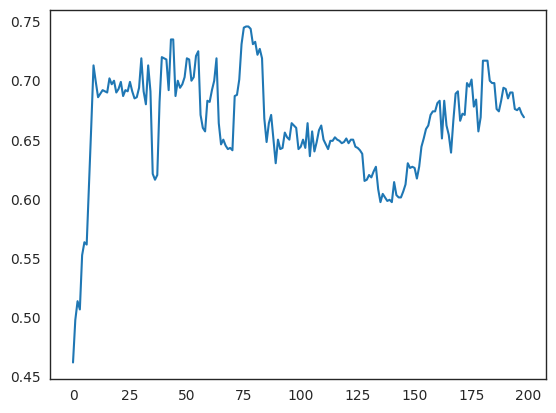

In [ ]:
n_opt = np.argmax(val_ci_clin_arr) + 1

plt.plot(val_ci_clin_arr)

In [202]:
PCs = [f"PC{i}" for i in range(1, n_opt + 1)]
Cox_train_clin = pd.concat([X_train_pca_clin_small[PCs], 
                            y_train.loc[clin_train_idx]], axis=1)
Cox_val_clin = pd.concat([X_val_pca_clin_small[PCs], 
                            y_val.loc[clin_val_idx]], axis=1)
Cox_test_clin = pd.concat([X_test_pca_clin_small[PCs], 
                            y_test.loc[clin_test_idx]], axis=1)

cox_clin = CoxPHFitter()
cox_clin.fit(
    Cox_train_clin,
    duration_col='event_time',
    event_col='event'
)

train_ci_clin = cox_clin.score(
    Cox_train_clin,
    scoring_method="concordance_index"
)

val_ci_clin = cox_clin.score(
    Cox_val_clin,
    scoring_method="concordance_index"
)

test_ci_clin = cox_clin.score(
    Cox_test_clin,
    scoring_method="concordance_index"
)

val_ci_clin, test_ci_clin

(np.float64(0.7457627118644068), np.float64(0.53))

# Metabolism Genes

In [203]:
metabol_genes = [
    "DPYD", "UGT1A1", "TPMT", "NUDT15",

    "CYP3A4", "CYP3A5", "CYP2D6", "CYP2C9", "CYP2C19", "CYP2B6",
    "CYP1A2", "CYP2A6", "CYP2C8",
    "CES1", "CES2", "CDA", "DCK",

    "UGT1A9", "UGT2B7",
    "SULT", "NAT1", "NAT2",
    "GSTM1", "GSTT1", "GSTP1",

    "ABCB1", "ABCC1", "ABCC2", "ABCC3", "ABCG2",
    "SLCO1B1", "SLCO1B3",
    "SLC22A1", "SLC22A2",
    "SLC47A1", "SLC47A2",
]

In [204]:
set(metabol_genes) & set(X_train_small.columns)

{'ABCC2',
 'ABCC3',
 'ABCG2',
 'CDA',
 'CES1',
 'CES2',
 'CYP2B6',
 'CYP2C19',
 'CYP3A4',
 'NAT2',
 'NUDT15',
 'TPMT',
 'UGT2B7'}

In [206]:
set(metabol_genes) - (set(metabol_genes) & set(X_train.columns) )

{'SLC22A2', 'SLCO1B1', 'SLCO1B3', 'SULT', 'UGT1A9'}

## Drug metabolism genes only

In [213]:
met_genes_in_dataset = list(set(metabol_genes) & set(X_train.columns))

Cox_train_met = pd.concat([X_train[met_genes_in_dataset], y_train], axis=1)
Cox_val_met = pd.concat([X_val[met_genes_in_dataset], y_val], axis=1)
Cox_test_met = pd.concat([X_test[met_genes_in_dataset], y_test], axis=1)

In [215]:
cox = CoxPHFitter().fit(Cox_train_met, event_col="event", duration_col="event_time")

print(cox.score(Cox_train_met, "concordance_index"))
print(cox.score(Cox_val_met, "concordance_index"))
print(cox.score(Cox_test_met, "concordance_index"))

0.6430524610087097
0.664274322169059
0.6980369515011547


In [218]:
cox.summary[cox.summary.p < 0.05]

,coef,exp(coef),se(coef),coef lower 95%,coef upper 95%,exp(coef) lower 95%,exp(coef) upper 95%,cmp to,z,p,-log2(p)
covariate,,,,,,,,,,,
TPMT,-0.087137,0.916551,0.040436,-0.166391,-0.007884,0.846715,0.992147,0.0,-2.154930,0.031167,5.003822
CES1,-0.480703,0.618349,0.199497,-0.871709,-0.089696,0.418236,0.914209,0.0,-2.409574,0.015971,5.968386
CYP2D6,0.082976,1.086516,0.038386,0.007742,0.158211,1.007772,1.171414,0.0,2.161643,0.030646,5.028170
SLC22A1,1.515562,4.551978,0.451042,0.631536,2.399588,1.880497,11.018633,0.0,3.360135,0.000779,10.326009
CES2,-0.049100,0.952086,0.023716,-0.095583,-0.002617,0.908843,0.997386,0.0,-2.070308,0.038423,4.701867


In [219]:
penalty_arr = np.logspace(-5, 1, 100)
ci_cal_arr_met = []

for p in tqdm(penalty_arr):
    cox = CoxPHFitter(penalizer=p).fit(Cox_train_met, event_col="event", duration_col="event_time")
    ci_cal_arr_met.append(cox.score(Cox_val_met, "concordance_index"))

100%|██████████| 100/100 [02:23<00:00,  1.44s/it]


0.00043287612810830614


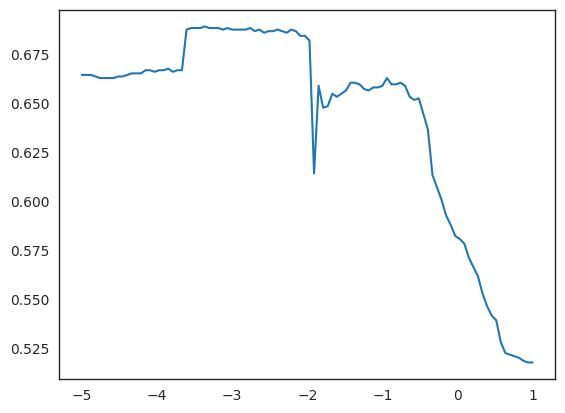

In [ ]:
n_opt_met = penalty_arr[np.argmax(ci_cal_arr_met)]
print(n_opt_met)

plt.plot(np.log(penalty_arr) / np.log(10), ci_cal_arr_met)

In [221]:
cox_met = CoxPHFitter(penalizer=n_opt_met).fit(Cox_train_met, event_col="event", duration_col="event_time")
cox_met.score(Cox_val_met, "concordance_index"), cox_met.score(Cox_test_met, "concordance_index")

(np.float64(0.6889952153110048), np.float64(0.6812933025404158))

In [223]:
cox_met.summary[cox_met.summary.p < 0.05]

,coef,exp(coef),se(coef),coef lower 95%,coef upper 95%,exp(coef) lower 95%,exp(coef) upper 95%,cmp to,z,p,-log2(p)
covariate,,,,,,,,,,,
TPMT,-0.078434,0.924563,0.039591,-0.156032,-0.000837,0.855532,0.999164,0.0,-1.981099,0.047580,4.393495
DPYD,0.065012,1.067172,0.032666,0.000988,0.129035,1.000989,1.137730,0.0,1.990222,0.046566,4.424564
CES1,-0.553875,0.574719,0.208922,-0.963353,-0.144396,0.381611,0.865545,0.0,-2.651114,0.008023,6.961699
CYP2D6,0.103607,1.109165,0.038809,0.027544,0.179671,1.027926,1.196823,0.0,2.669694,0.007592,7.041298
SLC22A1,1.535469,4.643504,0.445224,0.662846,2.408093,1.940307,11.112743,0.0,3.448756,0.000563,10.794128


### Drug metabolism genes with clinical data

In [233]:
Cox_train_clin_met = pd.merge(X_train[met_genes_in_dataset].reset_index(names="SAMPLE_ID"), 
                            clin_data.drop(["COHORT_MDACC", "COHORT_NHLBI"], axis=1), 
                            on="SAMPLE_ID", how="inner").set_index("SAMPLE_ID")
Cox_val_clin_met = pd.merge(X_val[met_genes_in_dataset].reset_index(names="SAMPLE_ID"), 
                            clin_data.drop(["COHORT_MDACC", "COHORT_NHLBI"], axis=1), 
                            on="SAMPLE_ID", how="inner").set_index("SAMPLE_ID")
Cox_test_clin_met = pd.merge(X_test[met_genes_in_dataset].reset_index(names="SAMPLE_ID"), 
                            clin_data.drop(["COHORT_MDACC", "COHORT_NHLBI"], axis=1), 
                            on="SAMPLE_ID", how="inner").set_index("SAMPLE_ID")

imputer = KNNImputer(weights="distance", n_neighbors=5)

Cox_train_clin_met = pd.DataFrame(imputer.fit_transform(Cox_train_clin_met), columns=Cox_train_clin_met.columns, index=Cox_train_clin_met.index)
Cox_val_clin_met = pd.DataFrame(imputer.transform(Cox_val_clin_met), columns=Cox_val_clin_met.columns, index=Cox_val_clin_met.index)
Cox_test_clin_met = pd.DataFrame(imputer.transform(Cox_test_clin_met), columns=Cox_test_clin_met.columns, index=Cox_test_clin_met.index)

Cox_train_clin_met

,ABCB1,UGT2B7,CYP2C8,NAT1,CDA,TPMT,ABCG2,CYP2A6,GSTT1,DPYD,...,TREATMENT_AFTER_SAMPLING_BTK inhibitor,TREATMENT_AFTER_SAMPLING_Chemo + Ab,TREATMENT_AFTER_SAMPLING_Chemo + no Ab,CLL_EPITYPE_i-CLL,CLL_EPITYPE_m-CLL,CLL_EPITYPE_n-CLL,TUMOR_MOLECULAR_SUBTYPE_M-CLL,TUMOR_MOLECULAR_SUBTYPE_U-CLL,U1_STATUS_MUT,U1_STATUS_WT
SAMPLE_ID,,,,,,,,,,,,,,,,,,,,,
GCLL-0025,1.801510,0.015140,0.645617,2.40373,0.532741,8.77359,0.162262,0.019280,41.01090,4.147430,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0
SCLL-0439,14.379000,0.000000,8.965050,3.86445,0.190757,11.91070,0.009473,0.698967,34.63970,9.246590,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
SCLL-0379,6.407490,0.000000,0.293763,2.80088,0.094653,7.46455,0.112810,0.719339,13.56480,0.375391,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
SCLL-0374,1.830660,0.013139,7.338010,2.81553,0.277383,9.48901,0.012244,0.150575,20.70970,0.122233,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
GCLL-0115,0.064894,0.000000,0.330602,2.85493,0.000000,2.56124,0.085452,0.000000,1.28836,1.588160,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
DFCI-5217,2.349420,0.000000,2.884100,3.40177,13.760500,12.08830,0.059637,0.027163,0.00000,4.858350,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
GCLL-0310,0.822651,0.028466,0.819112,2.91160,0.022259,8.83414,0.035371,0.120829,6.73191,1.275120,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
SCLL-0168,5.668750,0.000000,2.739530,3.01127,1.366480,8.05781,0.082611,0.903041,7.78141,2.679180,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0


In [238]:
penalty_arr = np.logspace(-5, 1, 100)
ci_cal_arr_met = []

for p in tqdm(penalty_arr):
    cox = CoxPHFitter(penalizer=p).fit(Cox_train_clin_met, event_col="event", duration_col="event_time")
    ci_cal_arr_met.append(cox.score(Cox_val_clin_met, "concordance_index"))

100%|██████████| 100/100 [00:26<00:00,  3.75it/s]


2.848035868435805


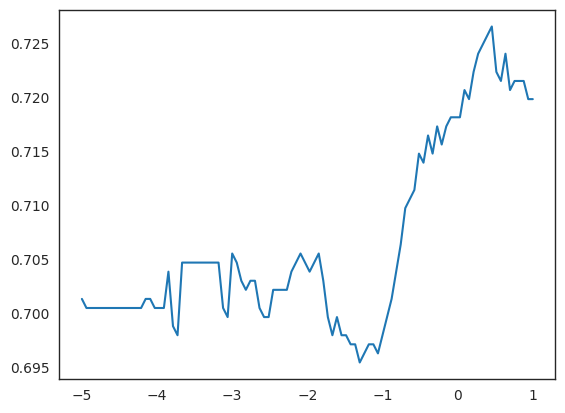

In [239]:
n_opt_met_clin = penalty_arr[np.argmax(ci_cal_arr_met)]
print(n_opt_met_clin)

plt.plot(np.log(penalty_arr) / np.log(10), ci_cal_arr_met)

In [240]:
cox_met_clin = CoxPHFitter(penalizer=n_opt_met_clin).fit(Cox_train_clin_met, event_col="event", duration_col="event_time")
cox_met_clin.score(Cox_val_clin_met, "concordance_index"), cox_met_clin.score(Cox_test_clin_met, "concordance_index")

(np.float64(0.7265100671140939), np.float64(0.6634304207119741))

In [241]:
cox_met_clin.summary[cox_met_clin.summary.p < 0.05]

,coef,exp(coef),se(coef),coef lower 95%,coef upper 95%,exp(coef) lower 95%,exp(coef) upper 95%,cmp to,z,p,-log2(p)
covariate,,,,,,,,,,,
COHORT_GCLLSG,0.154178,1.166698,0.060952,0.034713,0.273642,1.035323,1.314744,0.0,2.529477,0.011423,6.451880
COHORT_UCSD,-0.336333,0.714385,0.139819,-0.610374,-0.062292,0.543148,0.939609,0.0,-2.405478,0.016151,5.952203
TREATMENT_AFTER_SAMPLING_Chemo + Ab,-0.142197,0.867450,0.062315,-0.264332,-0.020062,0.767719,0.980138,0.0,-2.281915,0.022494,5.474292


### Drug metabolic genes with significant clinical cols

In [ ]:
cols_to_use = ['TMB_NONSYNONYMOUS',
              'COHORT_GCLLSG',
              'COHORT_UCSD',
              'TREATMENT_AFTER_SAMPLING_Chemo + Ab',
              'TREATMENT_AFTER_SAMPLING_Chemo + no Ab']

In [243]:
cox = CoxPHFitter().fit(Cox_train_clin_met[met_genes_in_dataset + cols_to_use + ["event", "event_time"]], event_col="event", duration_col="event_time")

print(cox.score(Cox_train_clin_met[met_genes_in_dataset + cols_to_use + ["event", "event_time"]], "concordance_index"))
print(cox.score(Cox_val_clin_met[met_genes_in_dataset + cols_to_use + ["event", "event_time"]], "concordance_index"))
print(cox.score(Cox_test_clin_met[met_genes_in_dataset + cols_to_use + ["event", "event_time"]], "concordance_index"))

0.7216556413083425
0.6954697986577181
0.6763754045307443


In [244]:
cox.summary[cox.summary.p < 0.05]

,coef,exp(coef),se(coef),coef lower 95%,coef upper 95%,exp(coef) lower 95%,exp(coef) upper 95%,cmp to,z,p,-log2(p)
covariate,,,,,,,,,,,
NAT1,-0.098648,0.906061,0.046520,-0.189825,-0.007471,0.827104,0.992557,0.0,-2.120567,0.033958,4.880092
TMB_NONSYNONYMOUS,-0.688207,0.502476,0.193324,-1.067115,-0.309300,0.343999,0.733961,0.0,-3.559868,0.000371,11.396134
COHORT_GCLLSG,1.599978,4.952923,0.333471,0.946386,2.253570,2.576383,9.521664,0.0,4.797949,0.000002,19.250806
COHORT_UCSD,-1.105363,0.331091,0.492778,-2.071190,-0.139535,0.126036,0.869762,0.0,-2.243124,0.024889,5.328360
TREATMENT_AFTER_SAMPLING_Chemo + Ab,-0.562723,0.569656,0.211874,-0.977989,-0.147457,0.376066,0.862900,0.0,-2.655928,0.007909,6.982281
TREATMENT_AFTER_SAMPLING_Chemo + no Ab,-0.709666,0.491808,0.292434,-1.282827,-0.136505,0.277252,0.872402,0.0,-2.426753,0.015235,6.036504
